In [1]:
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt
import cesium.featurize as featurize
from collections import Counter, OrderedDict
from operator import itemgetter
import seaborn as sns
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
pd.options.mode.use_inf_as_na = True

In [2]:
metafilename = 'training_set_metadata.csv'
metadata = pd.read_csv(metafilename)
metadata.head(1)

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,0.017,92


In [3]:
#Load previously generated cesium feature file
featurefile = 'C:/Users/Greg/Documents/Personal/PLAsTiCC/plasticc_featuretablemore.npz'
featuretable, _ = featurize.load_featureset(featurefile)
featuretable = featuretable.reset_index(level=0)
featuretable.head()

feature index all_times_nhist_numpeaks                           \
channel                              0    1    2    3    4    5   
0         615                     18.0  3.0  3.0  3.0  3.0  4.0   
1         713                     15.0  3.0  3.0  3.0  3.0  3.0   
2         730                     16.0  7.0  7.0  7.0  7.0  7.0   
3         745                     18.0  4.0  4.0  4.0  4.0  4.0   
4        1124                     18.0  3.0  3.0  3.0  3.0  4.0   

feature all_times_nhist_peak_val                       ...           std  \
channel                        0         1         2   ...             5   
0                       0.006097  0.004050  0.004050   ...    292.182295   
1                       0.006491  0.004738  0.004738   ...      7.030448   
2                       0.006176  0.004240  0.004240   ...     13.201397   
3                       0.005318  0.004374  0.004374   ...     25.822133   
4                       0.006097  0.004050  0.004050   ...     21.245772   

feature weighted_average                                                 \
channel                0           1           2           3          4   
0             -17.061118 -212.397193 -102.220639 -101.206639 -54.744845   
1              -3.500958   -1.322397   -1.030469   -1.382941  -1.407879   
2              -0.016423   -0.034170    2.059833    2.988513   4.486335   
3               1.176322    3.652226    6.716857   12.514694  12.247387   
4               0.824380    3.617169    7.842645    8.830427   8.463856   

feature             mwebv       z    zerr  
channel          5                         
0       -59.688379  0.017  0.0000  0.0000  
1        -1.876399  0.007  1.6267  0.2552  
2         5.057690  0.021  0.2262  0.0157  
3         8.760515  0.007  0.2813  1.1523  
4         5.602845  0.024  0.2415  0.0176  

[5 rows x 130 columns]

In [4]:
#Flatten index of the column names
old_names = featuretable.columns.values
pbmap = OrderedDict([(0,'u'), (1,'g'), (2,'r'), (3,'i'), (4, 'z'), (5, 'Y')])
pbnames = list(pbmap.values())
new_names = ['{}_{}'.format(x, pbmap.get(y,'meta')) for x,y in old_names]

In [5]:
featuretable.columns = featuretable.columns.droplevel(0)
featuretable.columns = new_names
featuretable.head()

,index_meta,all_times_nhist_numpeaks_u,all_times_nhist_numpeaks_g,all_times_nhist_numpeaks_r,all_times_nhist_numpeaks_i,all_times_nhist_numpeaks_z,all_times_nhist_numpeaks_Y,all_times_nhist_peak_val_u,all_times_nhist_peak_val_g,all_times_nhist_peak_val_r,...,std_Y,weighted_average_u,weighted_average_g,weighted_average_r,weighted_average_i,weighted_average_z,weighted_average_Y,mwebv_meta,z_meta,zerr_meta
0,615,18.0,3.0,3.0,3.0,3.0,4.0,0.006097,0.004050,0.004050,...,292.182295,-17.061118,-212.397193,-102.220639,-101.206639,-54.744845,-59.688379,0.017,0.0000,0.0000
1,713,15.0,3.0,3.0,3.0,3.0,3.0,0.006491,0.004738,0.004738,...,7.030448,-3.500958,-1.322397,-1.030469,-1.382941,-1.407879,-1.876399,0.007,1.6267,0.2552
2,730,16.0,7.0,7.0,7.0,7.0,7.0,0.006176,0.004240,0.004240,...,13.201397,-0.016423,-0.034170,2.059833,2.988513,4.486335,5.057690,0.021,0.2262,0.0157
3,745,18.0,4.0,4.0,4.0,4.0,4.0,0.005318,0.004374,0.004374,...,25.822133,1.176322,3.652226,6.716857,12.514694,12.247387,8.760515,0.007,0.2813,1.1523
4,1124,18.0,3.0,3.0,3.0,3.0,4.0,0.006097,0.004050,0.004050,...,21.245772,0.824380,3.617169,7.842645,8.830427,8.463856,5.602845,0.024,0.2415,0.0176


In [6]:
#Rename the object Id column to enable a merge:
featuretable = featuretable.rename(columns={"index_meta":"object_id"})
featuretable['object_id'] = featuretable.object_id.astype('int32')

In [7]:
df = pd.merge(metadata,featuretable, on="object_id")
df.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,...,std_Y,weighted_average_u,weighted_average_g,weighted_average_r,weighted_average_i,weighted_average_z,weighted_average_Y,mwebv_meta,z_meta,zerr_meta
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,...,292.182295,-17.061118,-212.397193,-102.220639,-101.206639,-54.744845,-59.688379,0.017,0.0000,0.0000
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,...,7.030448,-3.500958,-1.322397,-1.030469,-1.382941,-1.407879,-1.876399,0.007,1.6267,0.2552
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,...,13.201397,-0.016423,-0.034170,2.059833,2.988513,4.486335,5.057690,0.021,0.2262,0.0157
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,...,25.822133,1.176322,3.652226,6.716857,12.514694,12.247387,8.760515,0.007,0.2813,1.1523
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,...,21.245772,0.824380,3.617169,7.842645,8.830427,8.463856,5.602845,0.024,0.2415,0.0176


In [8]:
#One KNN model will treat only extragalactic sources, and one will 
#treat only galactic sources, so I'll split them up here:
egalmask = df['hostgal_specz'] != 0
extragal = df[egalmask]
extragal.groupby('target').agg('count')

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,...,std_Y,weighted_average_u,weighted_average_g,weighted_average_r,weighted_average_i,weighted_average_z,weighted_average_Y,mwebv_meta,z_meta,zerr_meta
target,,,,,,,,,,,,,,,,,,,,,
15,495,495,495,495,495,495,495,495,495,495,...,495,495,495,495,495,495,495,495,495,495
42,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,...,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193
52,183,183,183,183,183,183,183,183,183,183,...,183,183,183,183,183,183,183,183,183,183
62,484,484,484,484,484,484,484,484,484,484,...,484,484,484,484,484,484,484,484,484,484
64,102,102,102,102,102,102,102,102,102,102,...,102,102,102,102,102,102,102,102,102,102
67,208,208,208,208,208,208,208,208,208,208,...,208,208,208,208,208,208,208,208,208,208
88,370,370,370,370,370,370,370,370,370,370,...,370,370,370,370,370,370,370,370,370,370
90,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313,...,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313
95,175,175,175,175,175,175,175,175,175,175,...,175,175,175,175,175,175,175,175,175,175


In [9]:
#Drop cols I don't want to generate. Things like position in the sky or object Id are meaningless to simulate with SMOTE
Y = extragal['target']
extragal = extragal.drop(['object_id','target', 'ra', 'decl', 'gal_l', 'gal_b', 'ddf'], axis=1)
nans = pd.DataFrame(extragal.isnull().sum(axis=0), columns=['na'])
X = extragal.drop([x for x in nans[nans.na>0].index.values],axis=1)

display(X.shape)
Y.shape

(5523, 115)

(5523,)

In [10]:
#Confirm no NaNs
nans = pd.DataFrame(X.isnull().sum(axis=0), columns=['na'])
nans[nans.na>0]

,na


In [11]:
#Create extra samples and check how many were created

#Create SMOTE object
sm = SMOTE(sampling_strategy='not majority')
X_new, Y_new = sm.fit_resample(X,Y)
display(X_new.shape)

(20817, 115)

In [12]:
#Re-add target and confirm balance
df = pd.DataFrame(X_new, columns=X.columns)
df['target'] = Y_new
df.groupby('target').agg('count')

,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,all_times_nhist_numpeaks_u,all_times_nhist_numpeaks_g,all_times_nhist_numpeaks_r,all_times_nhist_numpeaks_i,all_times_nhist_numpeaks_z,...,std_Y,weighted_average_u,weighted_average_g,weighted_average_r,weighted_average_i,weighted_average_z,weighted_average_Y,mwebv_meta,z_meta,zerr_meta
target,,,,,,,,,,,,,,,,,,,,,
15,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313,...,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313
42,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313,...,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313
52,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313,...,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313
62,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313,...,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313
64,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313,...,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313
67,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313,...,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313
88,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313,...,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313
90,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313,...,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313
95,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313,...,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313


# Extra-galactic Feature Selection

In [13]:
#I picked these by eyeballing the above charts for arbitrarily significant differences between classes. 
#I'll use PCA to combine instances where the same measurements in different passbands provide similar information.
egalatts = df[['hostgal_specz', 'hostgal_photoz', 'distmod', 'all_times_nhist_numpeaks_g', 'all_times_nhist_numpeaks_r',
                     'all_times_nhist_numpeaks_z', 'all_times_nhist_numpeaks_Y', 'amplitude_u', 'amplitude_g', 
                     'percent_beyond_1_std_u', 'percent_beyond_1_std_g', 'percent_beyond_1_std_r', 'percent_beyond_1_std_i',
                     'percent_beyond_1_std_z', 'percent_beyond_1_std_Y', 'maximum_u', 'maximum_g', 'maximum_i', 'maximum_z',
                     'maximum_Y', 'max_slope_z', 'max_slope_Y', 'max_slope_g', 'median_u', 'median_i', 'median_z', 'median_Y', 
                     'median_absolute_deviation_g', 'median_absolute_deviation_z', 'median_absolute_deviation_Y',
                     'percent_close_to_median_u', 'percent_close_to_median_g', 'period_fast_r', 'period_fast_i', 
                     'period_fast_z', 'qso_log_chi2_qsonu_u', 'qso_log_chi2_qsonu_g', 'qso_log_chi2_qsonu_r', 
                     'qso_log_chi2_qsonu_i', 'qso_log_chi2_qsonu_Y', 'freq1_signif_g', 'freq1_signif_r', 'freq1_signif_i',
                     'freq1_signif_z', 'freq1_signif_Y', 'freq1_freq_u', 'freq1_freq_r', 'freq1_freq_g', 'linear_trend_u',
                     'linear_trend_g', 'linear_trend_r', 'linear_trend_i', 'linear_trend_z', 'minimum_z', 'skew_g', 'skew_r',
                     'skew_z', 'std_u', 'std_r', 'std_i', 'std_z', 'std_Y']]
#extragal.
egalatts.head()

,hostgal_specz,hostgal_photoz,distmod,all_times_nhist_numpeaks_g,all_times_nhist_numpeaks_r,all_times_nhist_numpeaks_z,all_times_nhist_numpeaks_Y,amplitude_u,amplitude_g,percent_beyond_1_std_u,...,linear_trend_z,minimum_z,skew_g,skew_r,skew_z,std_u,std_r,std_i,std_z,std_Y
0,1.8181,1.6267,45.4063,3.0,3.0,3.0,3.0,14.622504,10.422385,0.385714,...,-0.017949,-12.286801,-0.085494,-0.022066,-0.062403,7.062516,5.718981,6.392561,6.349526,7.030448
1,0.2320,0.2262,40.2561,7.0,7.0,7.0,7.0,4.701063,4.543094,0.333333,...,0.009337,-5.836310,0.457635,2.315707,2.462542,1.816127,5.505767,8.112835,10.604821,13.201397
2,0.3037,0.2813,40.7951,4.0,4.0,4.0,4.0,10.944189,97.931352,0.180556,...,-0.021154,-15.494463,6.817994,5.534683,3.382600,4.343961,31.671373,34.654080,32.772464,25.822133
3,0.1934,0.2415,40.4166,3.0,3.0,3.0,4.0,6.067815,19.896143,0.333333,...,0.020095,-16.543753,2.315295,2.995322,3.802308,2.341279,21.135263,26.043193,26.633303,21.245772
4,0.1352,0.1820,39.7279,3.0,3.0,3.0,4.0,141.604316,726.110041,0.095238,...,0.025086,-5.226799,5.159199,5.179738,5.113631,51.918012,215.250206,173.640682,129.250487,113.293962


# Examine cases where I kept the same feature for multiple passbands. if there correllations are high enough, use PCA to combine their information.

In [14]:
egalfeats = pd.DataFrame(index=egalatts.index)

In [15]:
enumpeaks = egalatts[['all_times_nhist_numpeaks_g', 'all_times_nhist_numpeaks_r',
       'all_times_nhist_numpeaks_z', 'all_times_nhist_numpeaks_Y']]
enumpeaks.corr()
#Combine these

,all_times_nhist_numpeaks_g,all_times_nhist_numpeaks_r,all_times_nhist_numpeaks_z,all_times_nhist_numpeaks_Y
all_times_nhist_numpeaks_g,1.000000,0.823488,0.831642,0.833640
all_times_nhist_numpeaks_r,0.823488,1.000000,0.846074,0.854685
all_times_nhist_numpeaks_z,0.831642,0.846074,1.000000,0.881950
all_times_nhist_numpeaks_Y,0.833640,0.854685,0.881950,1.000000


In [16]:
enumpeaks_scaler = StandardScaler().fit(enumpeaks)
X = enumpeaks_scaler.transform(enumpeaks)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))

%Variance explained by each component
 [0.88401127 0.0464689  0.04015581 0.02936402]


In [17]:
#91% explained by the best component
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

egalatts = egalatts.drop(['all_times_nhist_numpeaks_g', 'all_times_nhist_numpeaks_r',
       'all_times_nhist_numpeaks_z', 'all_times_nhist_numpeaks_Y'],axis=1)

egalfeats['numpeaks_grzY'] = Y

egalfeats.head()

,numpeaks_grzY
0,3.755479
1,2.066347
2,3.333196
3,3.661839
4,3.661839


--------

In [18]:
eamplitude = egalatts[['amplitude_u','amplitude_g']]
eamplitude.corr()
#Combine these

,amplitude_u,amplitude_g
amplitude_u,1.000000,0.951413
amplitude_g,0.951413,1.000000


In [19]:
eamplitude_scaler = StandardScaler().fit(eamplitude)
X = eamplitude_scaler.transform(eamplitude)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))

%Variance explained by each component
 [0.97570629 0.02429371]


In [20]:
P = eig_vec_cov[:, 1]
Y = P.T.dot(Xt)

egalatts = egalatts.drop([x for x in eamplitude.columns],axis=1)

egalfeats['amplitude_ug'] = Y

egalfeats.head()

,numpeaks_grzY,amplitude_ug
0,3.755479,-0.015184
1,2.066347,-0.012837
2,3.333196,0.060863
3,3.661839,-0.000970
4,3.661839,0.491592


--------

In [21]:
epctbey = egalatts[['percent_beyond_1_std_u',
       'percent_beyond_1_std_g', 'percent_beyond_1_std_r',
       'percent_beyond_1_std_i', 'percent_beyond_1_std_z',
       'percent_beyond_1_std_Y']]
epctbey.corr()
#Combine these

,percent_beyond_1_std_u,percent_beyond_1_std_g,percent_beyond_1_std_r,percent_beyond_1_std_i,percent_beyond_1_std_z,percent_beyond_1_std_Y
percent_beyond_1_std_u,1.000000,0.306526,0.209083,0.186853,0.184164,0.235096
percent_beyond_1_std_g,0.306526,1.000000,0.443578,0.399830,0.318697,0.325550
percent_beyond_1_std_r,0.209083,0.443578,1.000000,0.527457,0.364798,0.295190
percent_beyond_1_std_i,0.186853,0.399830,0.527457,1.000000,0.396913,0.334194
percent_beyond_1_std_z,0.184164,0.318697,0.364798,0.396913,1.000000,0.565072
percent_beyond_1_std_Y,0.235096,0.325550,0.295190,0.334194,0.565072,1.000000


In [22]:
#Not much to work with. After reviewing charts, g seems to provide the most new information about the classes, 
#So I'm going to basically take that plus it's highest correlation (r) and make a component from those.
epctbey = egalatts[[ 'percent_beyond_1_std_g', 'percent_beyond_1_std_r']]
epctbey_scaler = StandardScaler().fit(epctbey)
X = epctbey_scaler.transform(epctbey)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))

%Variance explained by each component
 [0.72178917 0.27821083]


In [23]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)
egalatts = egalatts.drop(['percent_beyond_1_std_u','percent_beyond_1_std_g', 'percent_beyond_1_std_r',
                          'percent_beyond_1_std_i', 'percent_beyond_1_std_z','percent_beyond_1_std_Y'],
                         axis=1)

egalfeats['epctbey_gr'] = Y

egalfeats.head()

,numpeaks_grzY,amplitude_ug,epctbey_gr
0,3.755479,-0.015184,1.928056
1,2.066347,-0.012837,0.551099
2,3.333196,0.060863,-2.079297
3,3.661839,-0.000970,-0.924318
4,3.661839,0.491592,-2.307035


-------------------

In [24]:
emaxes = egalatts[['maximum_u', 'maximum_g','maximum_i', 'maximum_z', 'maximum_Y']]
emaxes.corr()
#Combine these

,maximum_u,maximum_g,maximum_i,maximum_z,maximum_Y
maximum_u,1.000000,0.969287,0.936903,0.894865,0.883391
maximum_g,0.969287,1.000000,0.972864,0.924329,0.913729
maximum_i,0.936903,0.972864,1.000000,0.947335,0.945788
maximum_z,0.894865,0.924329,0.947335,1.000000,0.979213
maximum_Y,0.883391,0.913729,0.945788,0.979213,1.000000


In [25]:
emaxes_scaler = StandardScaler().fit(emaxes)
X = emaxes_scaler.transform(emaxes)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))
eig_val_cov

%Variance explained by each component
 [0.94949094 0.03402684 0.00920588 0.00301695 0.00425939]


array([4.74768276, 0.17014238, 0.04603161, 0.0150855 , 0.02129796])

In [26]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

egalatts = egalatts.drop([x for x in emaxes.columns],axis=1)

egalfeats['maxes_ugizy'] = Y

egalfeats.head()

,numpeaks_grzY,amplitude_ug,epctbey_gr,maxes_ugizy
0,3.755479,-0.015184,1.928056,0.359540
1,2.066347,-0.012837,0.551099,0.326993
2,3.333196,0.060863,-2.079297,0.109648
3,3.661839,-0.000970,-0.924318,0.209062
4,3.661839,0.491592,-2.307035,-1.044958


--------

In [27]:
emaxslopes = egalatts[['max_slope_z','max_slope_Y', 'max_slope_g']]
emaxslopes.corr()
#Combine these

,max_slope_z,max_slope_Y,max_slope_g
max_slope_z,1.000000,0.182080,0.168083
max_slope_Y,0.182080,1.000000,0.291255
max_slope_g,0.168083,0.291255,1.000000


In [28]:
emaxslopes_scaler = StandardScaler().fit(emaxslopes)
X = emaxslopes_scaler.transform(emaxslopes)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))
eig_val_cov

%Variance explained by each component
 [0.47763795 0.28628866 0.2360734 ]


array([1.43298268, 0.85890723, 0.70825421])

In [29]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

egalatts = egalatts.drop([x for x in emaxslopes.columns],axis=1)

egalfeats['maxslopes_gzy'] = Y

egalfeats.head()

,numpeaks_grzY,amplitude_ug,epctbey_gr,maxes_ugizy,maxslopes_gzy
0,3.755479,-0.015184,1.928056,0.359540,-0.653533
1,2.066347,-0.012837,0.551099,0.326993,-0.651046
2,3.333196,0.060863,-2.079297,0.109648,-0.620984
3,3.661839,-0.000970,-0.924318,0.209062,-0.624849
4,3.661839,0.491592,-2.307035,-1.044958,0.840565


--------

In [30]:
emedians = egalatts[['median_u', 'median_i','median_z', 'median_Y']]
emedians.corr()
#Combine these

,median_u,median_i,median_z,median_Y
median_u,1.000000,0.906715,0.912394,0.917910
median_i,0.906715,1.000000,0.984607,0.951502
median_z,0.912394,0.984607,1.000000,0.958114
median_Y,0.917910,0.951502,0.958114,1.000000


In [31]:
emedians_scaler = StandardScaler().fit(emedians)
X = emedians_scaler.transform(emedians)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))
eig_val_cov

%Variance explained by each component
 [0.95405087 0.02902257 0.01317339 0.00375317]


array([3.81638683, 0.11609587, 0.05269608, 0.01501339])

In [32]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

egalatts = egalatts.drop([x for x in emedians.columns],axis=1)

egalfeats['median_uizY'] = Y

egalfeats.head()

,numpeaks_grzY,amplitude_ug,epctbey_gr,maxes_ugizy,maxslopes_gzy,median_uizY
0,3.755479,-0.015184,1.928056,0.359540,-0.653533,0.193142
1,2.066347,-0.012837,0.551099,0.326993,-0.651046,0.131458
2,3.333196,0.060863,-2.079297,0.109648,-0.620984,0.117107
3,3.661839,-0.000970,-0.924318,0.209062,-0.624849,0.123211
4,3.661839,0.491592,-2.307035,-1.044958,0.840565,0.152617


--------

In [33]:
eMedAbsDev = egalatts[['median_absolute_deviation_g', 'median_absolute_deviation_z',
       'median_absolute_deviation_Y']]
eMedAbsDev.corr()
#Combine these

,median_absolute_deviation_g,median_absolute_deviation_z,median_absolute_deviation_Y
median_absolute_deviation_g,1.000000,0.905349,0.900920
median_absolute_deviation_z,0.905349,1.000000,0.919374
median_absolute_deviation_Y,0.900920,0.919374,1.000000


In [34]:
eMedAbsDev_scaler = StandardScaler().fit(eMedAbsDev)
X = eMedAbsDev_scaler.transform(eMedAbsDev)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))
eig_val_cov

%Variance explained by each component
 [0.93903951 0.03418526 0.02677523]


array([2.81725387, 0.10256069, 0.08032955])

In [35]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

egalatts = egalatts.drop([x for x in eMedAbsDev.columns],axis=1)

egalfeats['medianAbsDev_gzY'] = Y

egalfeats.head()

,numpeaks_grzY,amplitude_ug,epctbey_gr,maxes_ugizy,maxslopes_gzy,median_uizY,medianAbsDev_gzY
0,3.755479,-0.015184,1.928056,0.359540,-0.653533,0.193142,-0.330144
1,2.066347,-0.012837,0.551099,0.326993,-0.651046,0.131458,-0.431809
2,3.333196,0.060863,-2.079297,0.109648,-0.620984,0.117107,-0.414359
3,3.661839,-0.000970,-0.924318,0.209062,-0.624849,0.123211,-0.423076
4,3.661839,0.491592,-2.307035,-1.044958,0.840565,0.152617,-0.452897


--------

In [36]:
ePct2Med = egalatts[['percent_close_to_median_u', 'percent_close_to_median_g']]
ePct2Med.corr()
#Combine these

,percent_close_to_median_u,percent_close_to_median_g
percent_close_to_median_u,1.000000,0.451922
percent_close_to_median_g,0.451922,1.000000


In [37]:
#after reviewing correlation and the charts, these are different enough to keep separately. I'll scale them to keep
#the KNN model fair.
ePct2Medu_scaler = StandardScaler().fit(pd.DataFrame(ePct2Med.percent_close_to_median_u))
egalfeats['pct2Med_u'] = ePct2Medu_scaler.transform(pd.DataFrame(ePct2Med.percent_close_to_median_u))

ePct2Medg_scaler = StandardScaler().fit(pd.DataFrame(ePct2Med.percent_close_to_median_g))
egalfeats['pct2Med_g'] = ePct2Medg_scaler.transform(pd.DataFrame(ePct2Med.percent_close_to_median_g))


egalfeats.head()

,numpeaks_grzY,amplitude_ug,epctbey_gr,maxes_ugizy,maxslopes_gzy,median_uizY,medianAbsDev_gzY,pct2Med_u,pct2Med_g
0,3.755479,-0.015184,1.928056,0.359540,-0.653533,0.193142,-0.330144,-1.218600,-1.534092
1,2.066347,-0.012837,0.551099,0.326993,-0.651046,0.131458,-0.431809,-0.459737,-0.316842
2,3.333196,0.060863,-2.079297,0.109648,-0.620984,0.117107,-0.414359,0.757307,1.661189
3,3.661839,-0.000970,-0.924318,0.209062,-0.624849,0.123211,-0.423076,-0.040419,0.638069
4,3.661839,0.491592,-2.307035,-1.044958,0.840565,0.152617,-0.452897,2.414124,1.666436


In [38]:
egalatts = egalatts.drop(['percent_close_to_median_u', 'percent_close_to_median_g'], axis=1)

--------

In [39]:
ePeriodFast = egalatts[['period_fast_r','period_fast_i', 'period_fast_z']]
ePeriodFast.corr()
#Combine these

,period_fast_r,period_fast_i,period_fast_z
period_fast_r,1.000000,0.502763,0.423829
period_fast_i,0.502763,1.000000,0.465818
period_fast_z,0.423829,0.465818,1.000000


In [40]:
ePeriodFast_scaler = StandardScaler().fit(ePeriodFast)
X = ePeriodFast_scaler.transform(ePeriodFast)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))
eig_val_cov

%Variance explained by each component
 [0.64300604 0.19370834 0.16328562]


array([1.92911078, 0.58115295, 0.48988039])

In [41]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

egalatts = egalatts.drop([x for x in ePeriodFast.columns],axis=1)

egalfeats['periodFast_riz'] = Y

egalfeats.head()

,numpeaks_grzY,amplitude_ug,epctbey_gr,maxes_ugizy,maxslopes_gzy,median_uizY,medianAbsDev_gzY,pct2Med_u,pct2Med_g,periodFast_riz
0,3.755479,-0.015184,1.928056,0.359540,-0.653533,0.193142,-0.330144,-1.218600,-1.534092,-0.853309
1,2.066347,-0.012837,0.551099,0.326993,-0.651046,0.131458,-0.431809,-0.459737,-0.316842,0.088611
2,3.333196,0.060863,-2.079297,0.109648,-0.620984,0.117107,-0.414359,0.757307,1.661189,-1.951828
3,3.661839,-0.000970,-0.924318,0.209062,-0.624849,0.123211,-0.423076,-0.040419,0.638069,0.109972
4,3.661839,0.491592,-2.307035,-1.044958,0.840565,0.152617,-0.452897,2.414124,1.666436,0.610842


--------

In [42]:
e_qlc2q = egalatts[['qso_log_chi2_qsonu_u',
       'qso_log_chi2_qsonu_g', 'qso_log_chi2_qsonu_r', 'qso_log_chi2_qsonu_i',
       'qso_log_chi2_qsonu_Y']]
e_qlc2q.corr()
#Combine these

,qso_log_chi2_qsonu_u,qso_log_chi2_qsonu_g,qso_log_chi2_qsonu_r,qso_log_chi2_qsonu_i,qso_log_chi2_qsonu_Y
qso_log_chi2_qsonu_u,1.000000,0.712702,0.613933,0.559747,0.528026
qso_log_chi2_qsonu_g,0.712702,1.000000,0.768937,0.700684,0.587409
qso_log_chi2_qsonu_r,0.613933,0.768937,1.000000,0.811920,0.680330
qso_log_chi2_qsonu_i,0.559747,0.700684,0.811920,1.000000,0.754256
qso_log_chi2_qsonu_Y,0.528026,0.587409,0.680330,0.754256,1.000000


In [43]:
e_qlc2q_scaler = StandardScaler().fit(e_qlc2q)
X = e_qlc2q_scaler.transform(e_qlc2q)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))
eig_val_cov

%Variance explained by each component
 [0.73931531 0.11471761 0.07078783 0.04169448 0.03348477]


array([3.69675411, 0.57361563, 0.35395615, 0.20848241, 0.16743189])

In [44]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

egalatts = egalatts.drop([x for x in e_qlc2q.columns],axis=1)

egalfeats['qlc2q_ugriY'] = Y

egalfeats.head()

,numpeaks_grzY,amplitude_ug,epctbey_gr,maxes_ugizy,maxslopes_gzy,median_uizY,medianAbsDev_gzY,pct2Med_u,pct2Med_g,periodFast_riz,qlc2q_ugriY
0,3.755479,-0.015184,1.928056,0.359540,-0.653533,0.193142,-0.330144,-1.218600,-1.534092,-0.853309,-0.261363
1,2.066347,-0.012837,0.551099,0.326993,-0.651046,0.131458,-0.431809,-0.459737,-0.316842,0.088611,-1.124556
2,3.333196,0.060863,-2.079297,0.109648,-0.620984,0.117107,-0.414359,0.757307,1.661189,-1.951828,1.962863
3,3.661839,-0.000970,-0.924318,0.209062,-0.624849,0.123211,-0.423076,-0.040419,0.638069,0.109972,0.626203
4,3.661839,0.491592,-2.307035,-1.044958,0.840565,0.152617,-0.452897,2.414124,1.666436,0.610842,4.247247


--------

In [45]:
eFreqSig = egalatts[['freq1_signif_g',
       'freq1_signif_r', 'freq1_signif_i', 'freq1_signif_z', 'freq1_signif_Y']]
eFreqSig.corr()
#Combine these

,freq1_signif_g,freq1_signif_r,freq1_signif_i,freq1_signif_z,freq1_signif_Y
freq1_signif_g,1.000000,0.918809,0.913339,0.898825,0.800699
freq1_signif_r,0.918809,1.000000,0.943312,0.909926,0.798875
freq1_signif_i,0.913339,0.943312,1.000000,0.952695,0.842727
freq1_signif_z,0.898825,0.909926,0.952695,1.000000,0.890834
freq1_signif_Y,0.800699,0.798875,0.842727,0.890834,1.000000


In [46]:
eFreqSig_scaler = StandardScaler().fit(eFreqSig)
X = eFreqSig_scaler.transform(eFreqSig)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))
eig_val_cov

%Variance explained by each component
 [0.9102299  0.04949096 0.01957482 0.01345275 0.00725156]


array([4.55136814, 0.2474667 , 0.09787881, 0.06726699, 0.03625955])

In [47]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

egalatts = egalatts.drop([x for x in eFreqSig.columns],axis=1)

egalfeats['freqSig_grizy'] = Y

egalfeats.head()

,numpeaks_grzY,amplitude_ug,epctbey_gr,maxes_ugizy,maxslopes_gzy,median_uizY,medianAbsDev_gzY,pct2Med_u,pct2Med_g,periodFast_riz,qlc2q_ugriY,freqSig_grizy
0,3.755479,-0.015184,1.928056,0.359540,-0.653533,0.193142,-0.330144,-1.218600,-1.534092,-0.853309,-0.261363,-2.444219
1,2.066347,-0.012837,0.551099,0.326993,-0.651046,0.131458,-0.431809,-0.459737,-0.316842,0.088611,-1.124556,-3.056355
2,3.333196,0.060863,-2.079297,0.109648,-0.620984,0.117107,-0.414359,0.757307,1.661189,-1.951828,1.962863,-3.482028
3,3.661839,-0.000970,-0.924318,0.209062,-0.624849,0.123211,-0.423076,-0.040419,0.638069,0.109972,0.626203,-4.316538
4,3.661839,0.491592,-2.307035,-1.044958,0.840565,0.152617,-0.452897,2.414124,1.666436,0.610842,4.247247,2.925465


--------

In [48]:
eFreq = egalatts[['freq1_freq_u',
       'freq1_freq_r', 'freq1_freq_g']]
eFreq.corr()
#Combine these

,freq1_freq_u,freq1_freq_r,freq1_freq_g
freq1_freq_u,1.000000,0.187304,0.201181
freq1_freq_r,0.187304,1.000000,0.259870
freq1_freq_g,0.201181,0.259870,1.000000


In [49]:
eFreq_scaler = StandardScaler().fit(eFreq)
X = eFreq_scaler.transform(eFreq)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))
eig_val_cov

%Variance explained by each component
 [0.47795187 0.27561555 0.24643258]


array([1.43392448, 0.82688638, 0.73933326])

In [50]:
#Leaving those out completely for now

egalatts = egalatts.drop([x for x in eFreq.columns],axis=1)

--------

In [51]:
eLinear = egalatts[['linear_trend_u',
       'linear_trend_g', 'linear_trend_r', 'linear_trend_i', 'linear_trend_z']]
eLinear.corr()
#Combine these

,linear_trend_u,linear_trend_g,linear_trend_r,linear_trend_i,linear_trend_z
linear_trend_u,1.000000,0.676643,0.717976,0.543935,0.421269
linear_trend_g,0.676643,1.000000,0.839336,0.841165,0.712380
linear_trend_r,0.717976,0.839336,1.000000,0.847284,0.633238
linear_trend_i,0.543935,0.841165,0.847284,1.000000,0.827901
linear_trend_z,0.421269,0.712380,0.633238,0.827901,1.000000


In [52]:
eLinear_scaler = StandardScaler().fit(eLinear)
X = eLinear_scaler.transform(eLinear)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))
eig_val_cov

%Variance explained by each component
 [0.76978596 0.13084366 0.05182689 0.01561584 0.03192765]


array([3.8491147 , 0.65424975, 0.25914691, 0.07808295, 0.1596459 ])

In [53]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

egalatts = egalatts.drop([x for x in eLinear.columns],axis=1)

egalfeats['linear_ugriz'] = Y

egalfeats.head()

,numpeaks_grzY,amplitude_ug,epctbey_gr,maxes_ugizy,maxslopes_gzy,median_uizY,medianAbsDev_gzY,pct2Med_u,pct2Med_g,periodFast_riz,qlc2q_ugriY,freqSig_grizy,linear_ugriz
0,3.755479,-0.015184,1.928056,0.359540,-0.653533,0.193142,-0.330144,-1.218600,-1.534092,-0.853309,-0.261363,-2.444219,-0.482318
1,2.066347,-0.012837,0.551099,0.326993,-0.651046,0.131458,-0.431809,-0.459737,-0.316842,0.088611,-1.124556,-3.056355,-0.045268
2,3.333196,0.060863,-2.079297,0.109648,-0.620984,0.117107,-0.414359,0.757307,1.661189,-1.951828,1.962863,-3.482028,-1.062260
3,3.661839,-0.000970,-0.924318,0.209062,-0.624849,0.123211,-0.423076,-0.040419,0.638069,0.109972,0.626203,-4.316538,0.140869
4,3.661839,0.491592,-2.307035,-1.044958,0.840565,0.152617,-0.452897,2.414124,1.666436,0.610842,4.247247,2.925465,0.468586


In [54]:
egalatts.columns

Index(['hostgal_specz', 'hostgal_photoz', 'distmod', 'minimum_z', 'skew_g',
       'skew_r', 'skew_z', 'std_u', 'std_r', 'std_i', 'std_z', 'std_Y'],
      dtype='object')

In [55]:
eminz_scaler = StandardScaler().fit(pd.DataFrame(egalatts.minimum_z))
egalfeats['minimum_z'] = eminz_scaler.transform(pd.DataFrame(egalatts.minimum_z))

egalatts = egalatts.drop(['minimum_z'],axis=1)


--------

In [56]:
eSkew = egalatts[['skew_g', 'skew_r','skew_z']]
eSkew.corr()
#Combine these

,skew_g,skew_r,skew_z
skew_g,1.000000,0.500304,0.340395
skew_r,0.500304,1.000000,0.398946
skew_z,0.340395,0.398946,1.000000


In [57]:
eSkew_scaler = StandardScaler().fit(eSkew)
X = eSkew_scaler.transform(eSkew)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))
eig_val_cov

%Variance explained by each component
 [0.61002582 0.164148   0.22582618]


array([1.83016539, 0.49246766, 0.67751108])

In [58]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

egalatts = egalatts.drop([x for x in eSkew.columns],axis=1)

egalfeats['skew_grz'] = Y

egalfeats.head()

,numpeaks_grzY,amplitude_ug,epctbey_gr,maxes_ugizy,maxslopes_gzy,median_uizY,medianAbsDev_gzY,pct2Med_u,pct2Med_g,periodFast_riz,qlc2q_ugriY,freqSig_grizy,linear_ugriz,minimum_z,skew_grz
0,3.755479,-0.015184,1.928056,0.359540,-0.653533,0.193142,-0.330144,-1.218600,-1.534092,-0.853309,-0.261363,-2.444219,-0.482318,0.246451,2.289988
1,2.066347,-0.012837,0.551099,0.326993,-0.651046,0.131458,-0.431809,-0.459737,-0.316842,0.088611,-1.124556,-3.056355,-0.045268,0.331307,-0.089615
2,3.333196,0.060863,-2.079297,0.109648,-0.620984,0.117107,-0.414359,0.757307,1.661189,-1.951828,1.962863,-3.482028,-1.062260,0.204255,-4.730269
3,3.661839,-0.000970,-0.924318,0.209062,-0.624849,0.123211,-0.423076,-0.040419,0.638069,0.109972,0.626203,-4.316538,0.140869,0.190451,-1.784424
4,3.661839,0.491592,-2.307035,-1.044958,0.840565,0.152617,-0.452897,2.414124,1.666436,0.610842,4.247247,2.925465,0.468586,0.339325,-4.582744


--------

In [59]:
eStd = egalatts[['std_u', 'std_r', 'std_i', 'std_z', 'std_Y']]
eStd.corr()
#Combine these

,std_u,std_r,std_i,std_z,std_Y
std_u,1.000000,0.915838,0.923177,0.888341,0.880957
std_r,0.915838,1.000000,0.988448,0.954187,0.949255
std_i,0.923177,0.988448,1.000000,0.966186,0.963301
std_z,0.888341,0.954187,0.966186,1.000000,0.985822
std_Y,0.880957,0.949255,0.963301,0.985822,1.000000


In [60]:
eStd_scaler = StandardScaler().fit(eStd)
X = eStd_scaler.transform(eStd)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))
eig_val_cov

%Variance explained by each component
 [0.95352715 0.02970179 0.01200091 0.00194803 0.00282211]


array([4.76786481, 0.1485161 , 0.06000745, 0.00974064, 0.0141112 ])

In [61]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

egalatts = egalatts.drop([x for x in eStd.columns],axis=1)

egalfeats['std_urizy'] = Y

egalfeats.head()

,numpeaks_grzY,amplitude_ug,epctbey_gr,maxes_ugizy,maxslopes_gzy,median_uizY,medianAbsDev_gzY,pct2Med_u,pct2Med_g,periodFast_riz,qlc2q_ugriY,freqSig_grizy,linear_ugriz,minimum_z,skew_grz,std_urizy
0,3.755479,-0.015184,1.928056,0.359540,-0.653533,0.193142,-0.330144,-1.218600,-1.534092,-0.853309,-0.261363,-2.444219,-0.482318,0.246451,2.289988,0.368242
1,2.066347,-0.012837,0.551099,0.326993,-0.651046,0.131458,-0.431809,-0.459737,-0.316842,0.088611,-1.124556,-3.056355,-0.045268,0.331307,-0.089615,0.355187
2,3.333196,0.060863,-2.079297,0.109648,-0.620984,0.117107,-0.414359,0.757307,1.661189,-1.951828,1.962863,-3.482028,-1.062260,0.204255,-4.730269,0.235126
3,3.661839,-0.000970,-0.924318,0.209062,-0.624849,0.123211,-0.423076,-0.040419,0.638069,0.109972,0.626203,-4.316538,0.140869,0.190451,-1.784424,0.276825
4,3.661839,0.491592,-2.307035,-1.044958,0.840565,0.152617,-0.452897,2.414124,1.666436,0.610842,4.247247,2.925465,0.468586,0.339325,-4.582744,-0.483792


In [62]:
egalatts.columns

Index(['hostgal_specz', 'hostgal_photoz', 'distmod'], dtype='object')

In [63]:
hostgal_photoz_scaler = StandardScaler().fit(pd.DataFrame(egalatts.hostgal_photoz))
egalfeats['hostgal_photoz'] = hostgal_photoz_scaler.transform(pd.DataFrame(egalatts.hostgal_photoz))

hostgal_specz_scaler = StandardScaler().fit(pd.DataFrame(egalatts.hostgal_specz))
egalfeats['hostgal_specz'] = hostgal_specz_scaler.transform(pd.DataFrame(egalatts.hostgal_specz))


distmod_scaler = StandardScaler().fit(pd.DataFrame(egalatts.distmod))
egalfeats['distmod'] = distmod_scaler.transform(pd.DataFrame(egalatts.distmod))

In [64]:
del egalatts

In [65]:
#Split X,Y
egalX = egalfeats
egalY = df['target']


#Create Train/Test splits
egalX_train, egalX_test, egalY_train, egalY_test = train_test_split(
    egalX, egalY, test_size=0.5)


egalknn = KNeighborsClassifier(n_neighbors=15, weights='distance')
egalknn.fit(egalX_train, egalY_train)

egalknn.score(egalX_test, egalY_test)

0.7487750984724757

In [66]:
#This is just so I can confirm that the matrix is labelling classes correctly
counts = Counter(df['target'])
egalLabels, values = zip(*sorted(counts.items(), key=itemgetter(1)))

esrt = sorted(egalLabels)
counts

Counter({88: 2313,
         42: 2313,
         90: 2313,
         67: 2313,
         95: 2313,
         62: 2313,
         15: 2313,
         52: 2313,
         64: 2313})

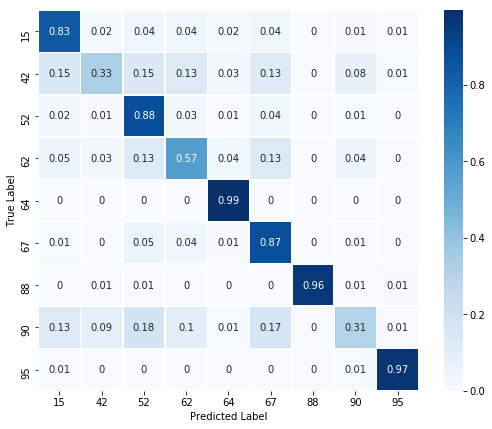

In [67]:
egalY_pred = egalknn.predict(egalX_test)
cm = confusion_matrix(egalY_test, egalY_pred,labels = esrt)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot = np.around(cm, 2)
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm, yticklabels=esrt, xticklabels=esrt, cmap='Blues',annot = annot, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')

In [68]:
scores = cross_val_score(egalknn,egalX,egalY, cv=10)
display(scores)
scores.mean()

array([0.80124521, 0.80076628, 0.78735632, 0.7955748 , 0.78114478,
       0.7989418 , 0.7974988 , 0.79461279, 0.7994228 , 0.8047138 ])

0.7961277388001526

# SVM attempt on same data


In [69]:
from sklearn.svm import SVC
svc = SVC(gamma='auto')

svc.fit(egalX_train, egalY_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [70]:
scores = cross_val_score(svc, egalX_train, egalY_train, cv=10)
display(scores)
scores.mean()

array([0.68516746, 0.6861244 , 0.7008629 , 0.69260327, 0.66666667,
       0.69615385, 0.68046198, 0.70741097, 0.69653179, 0.67695275])

0.6888936035417437

In [71]:
#Looks like back to feature selection for KNN!
del svc

# Feature recheck, post-scaling
Based on the above confusion matrix, I need to look specifically for variables in my set that, once scaled, differentiate classes 42, 62, and 90. 
Most specifically, here's the differences I need to emphacize:

**42 from:** 52, 15, 62, 67, 90   
**90 from:** 67, 52, 15, 62    
**62 from:** 52, 67, 64

c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


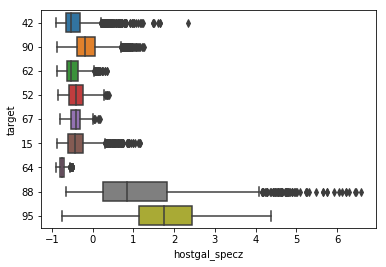

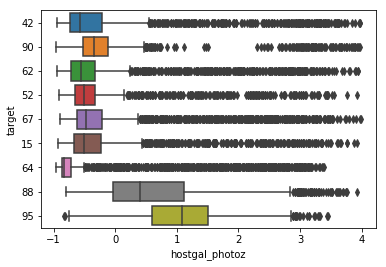

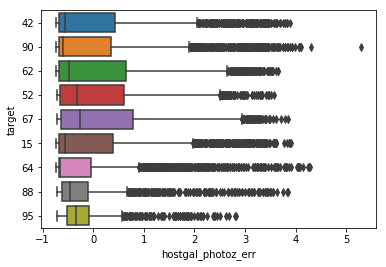

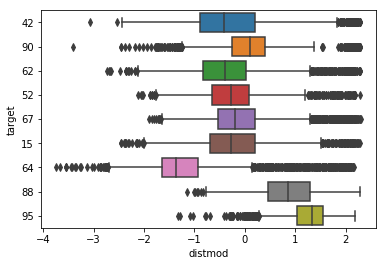

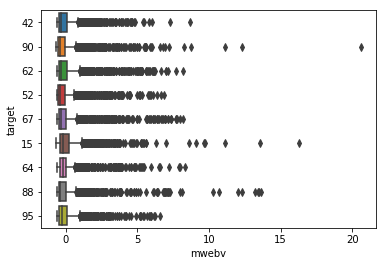

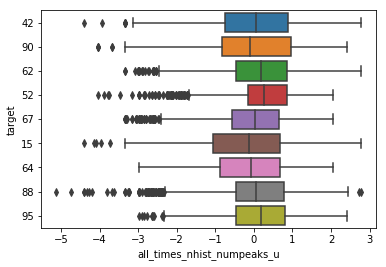

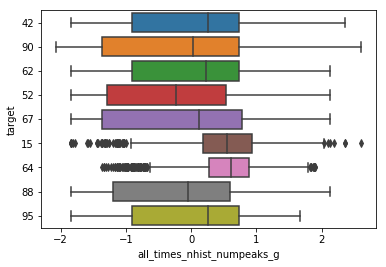

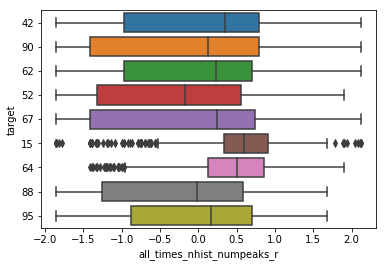

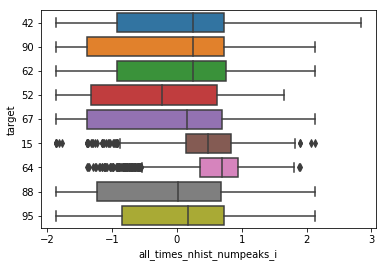

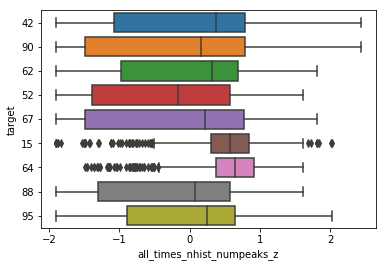

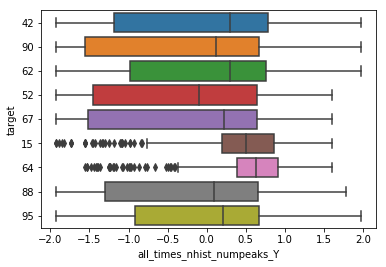

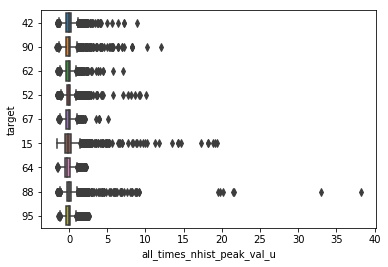

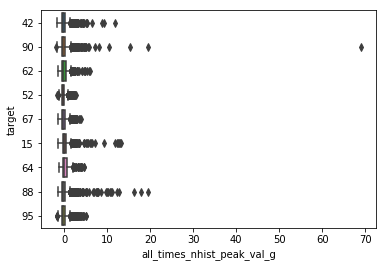

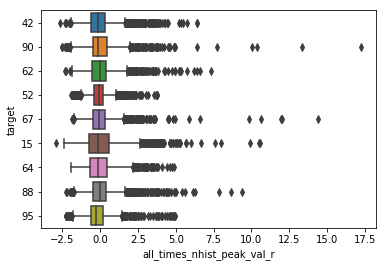

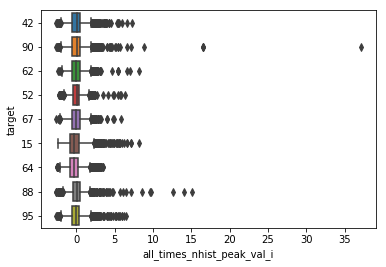

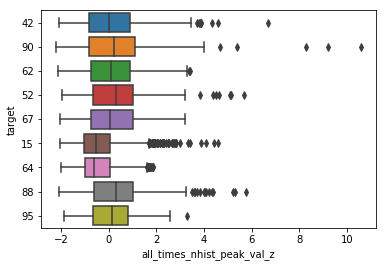

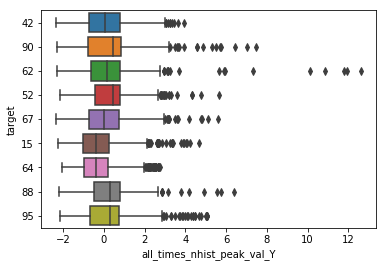

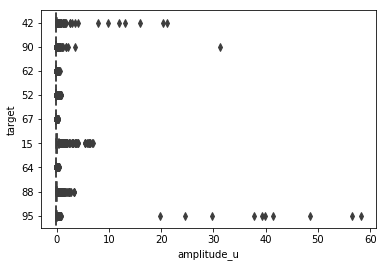

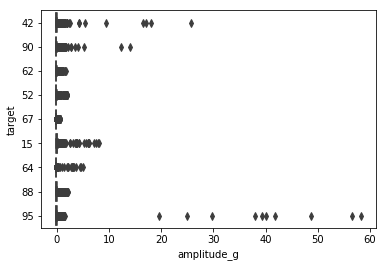

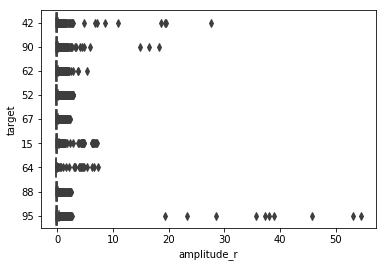

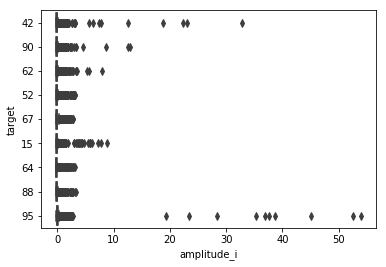

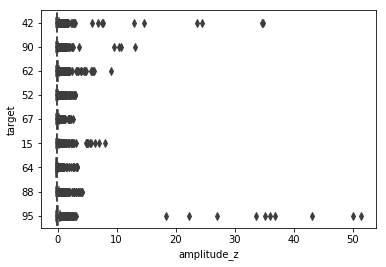

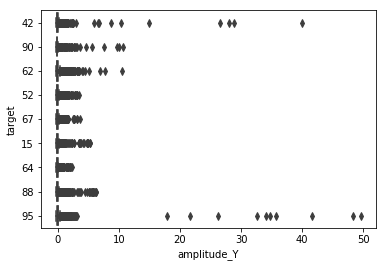

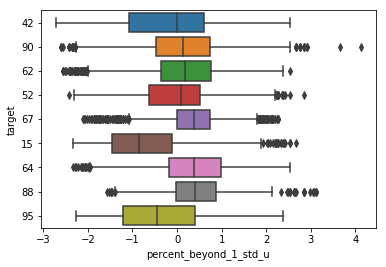

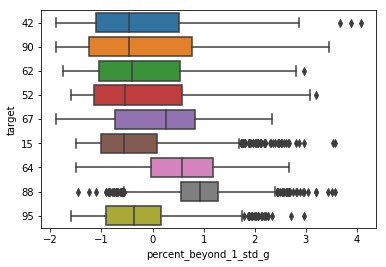

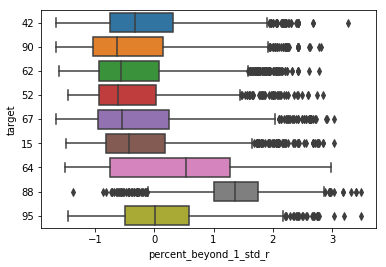

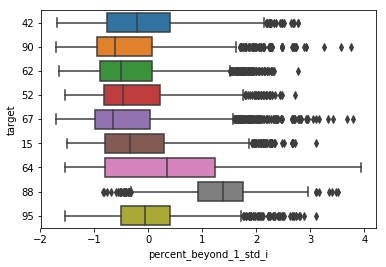

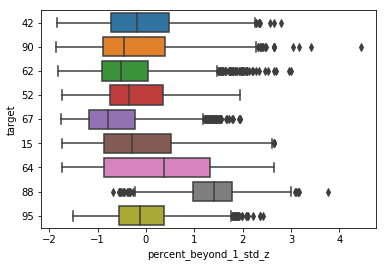

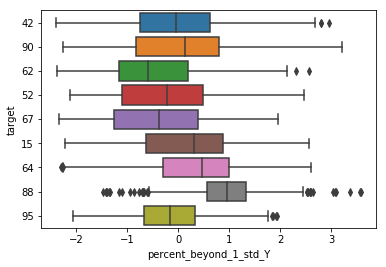

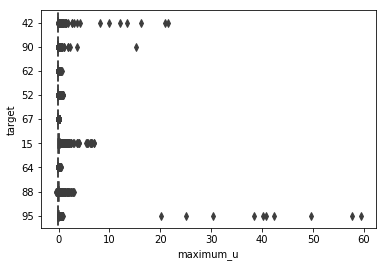

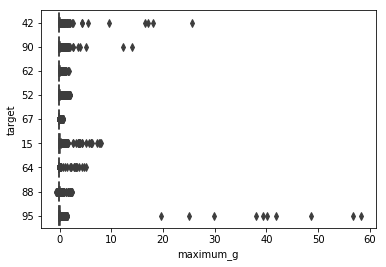

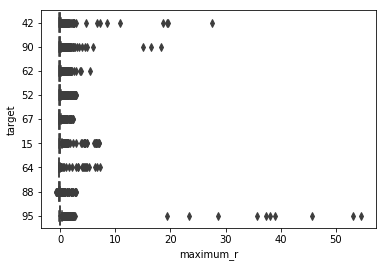

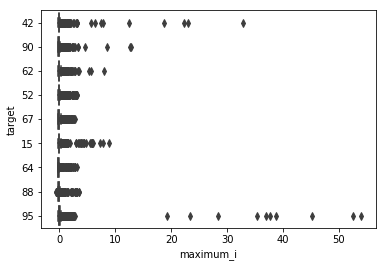

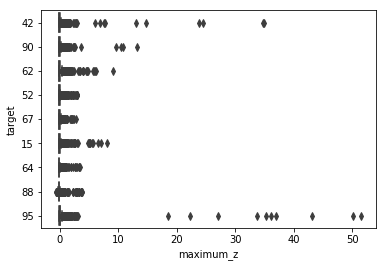

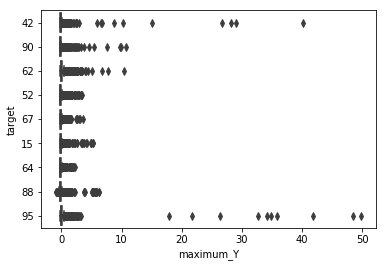

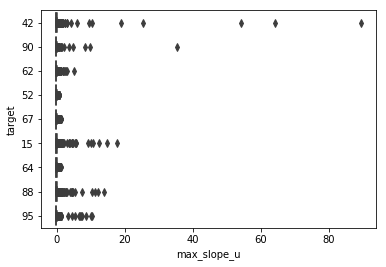

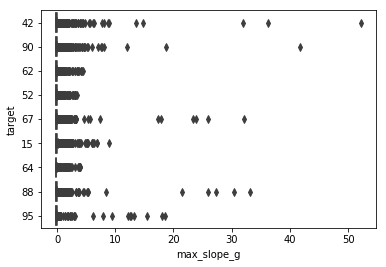

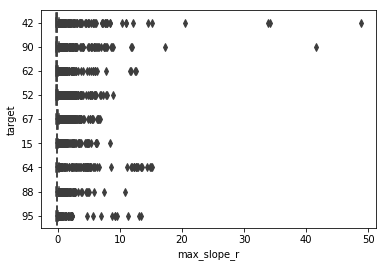

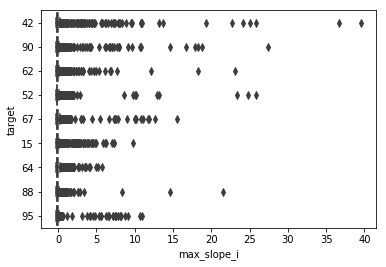

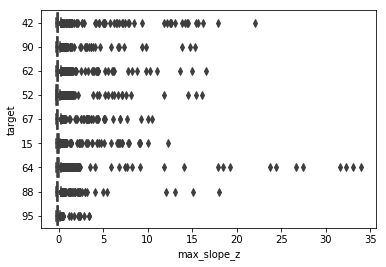

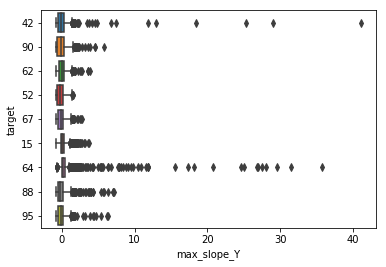

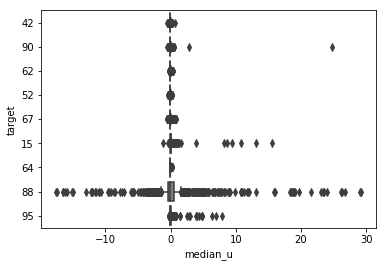

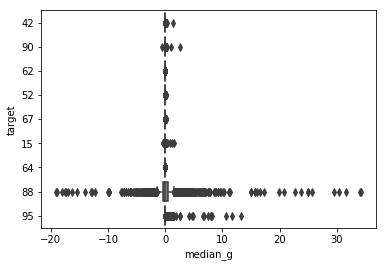

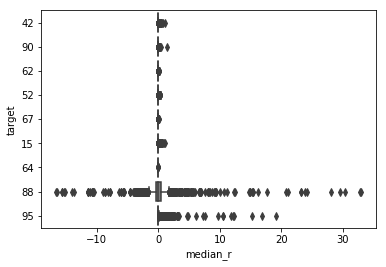

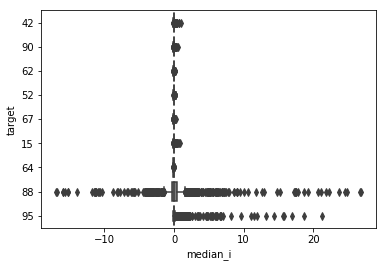

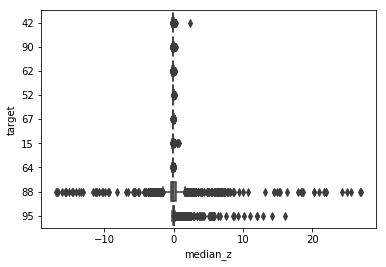

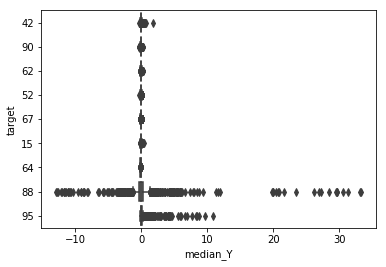

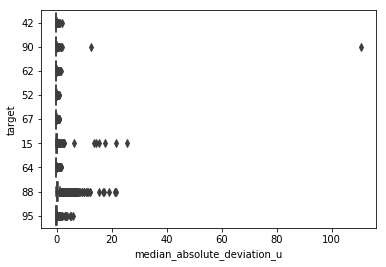

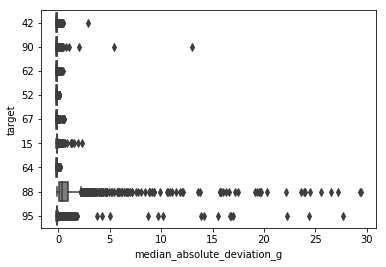

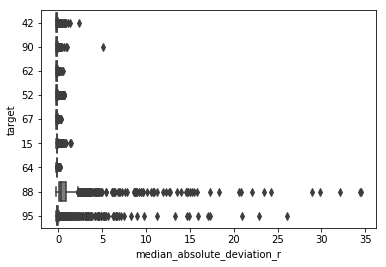

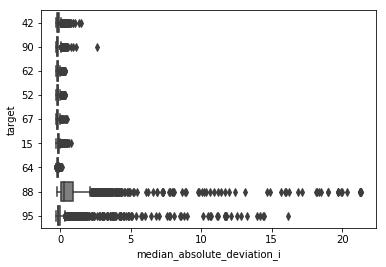

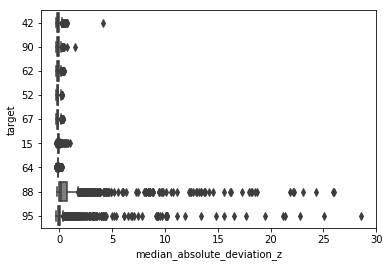

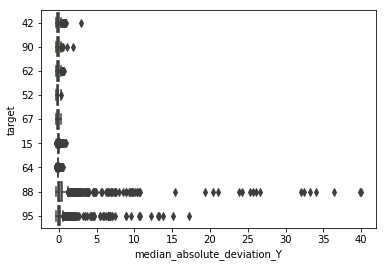

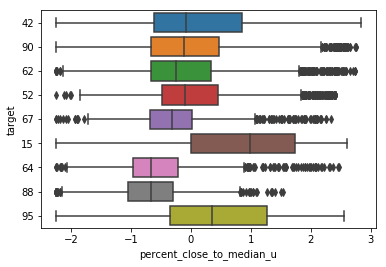

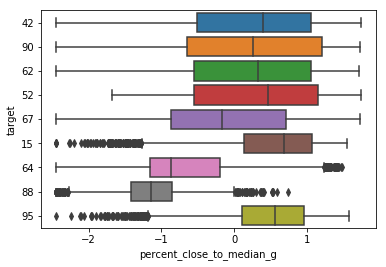

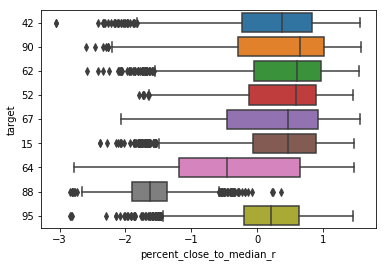

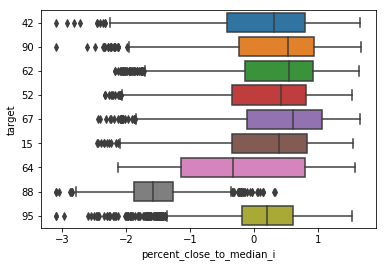

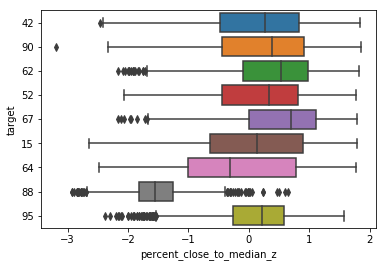

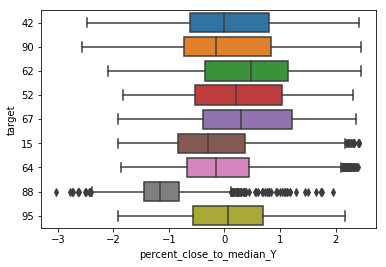

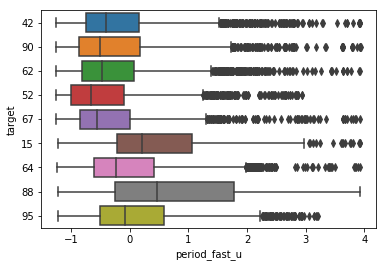

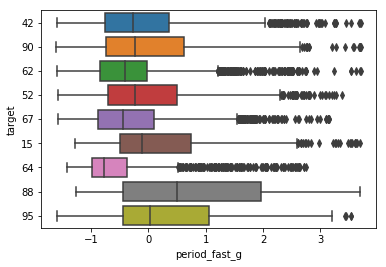

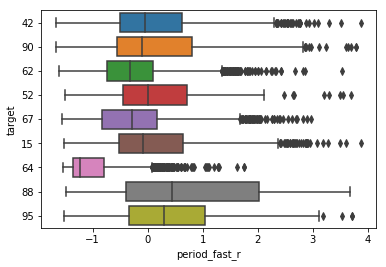

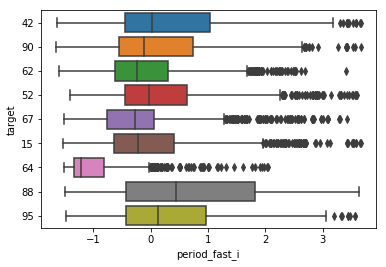

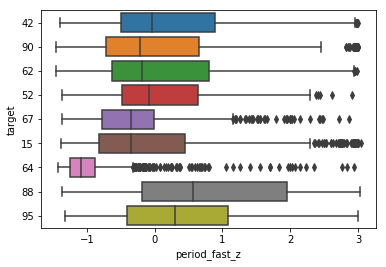

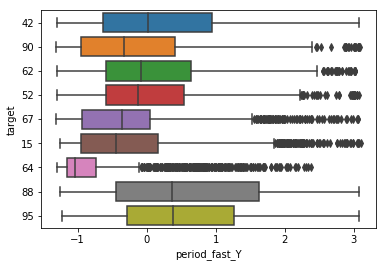

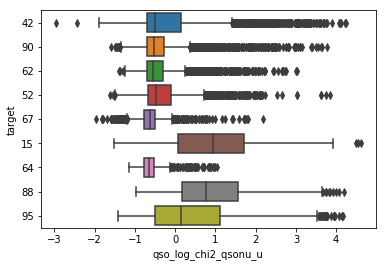

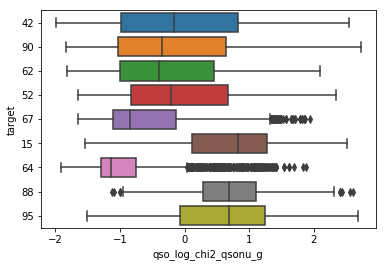

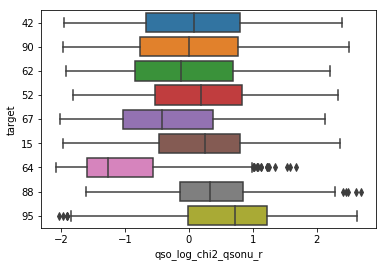

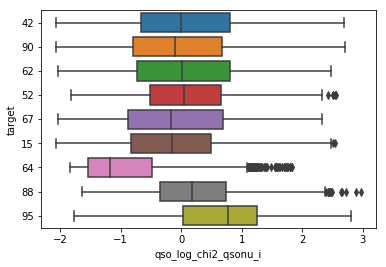

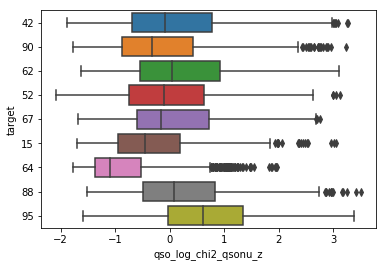

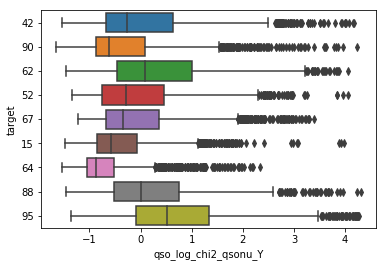

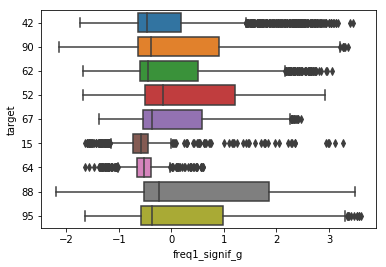

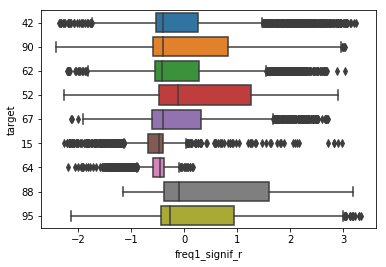

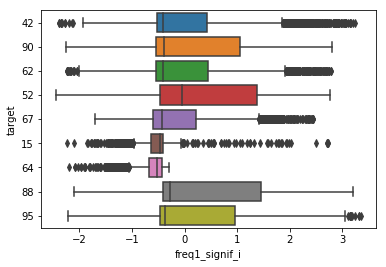

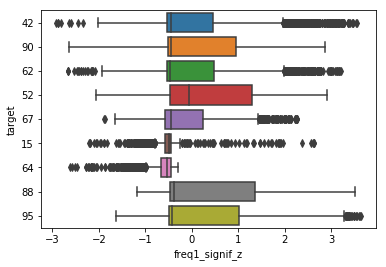

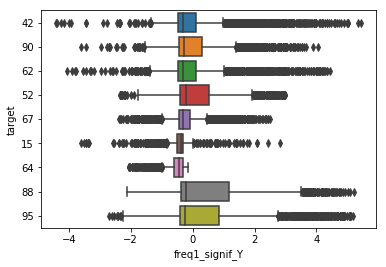

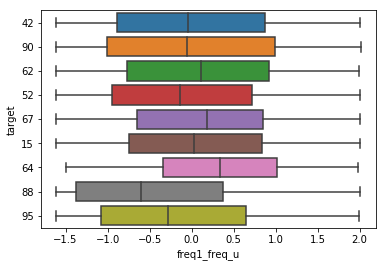

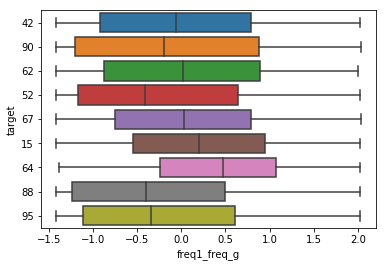

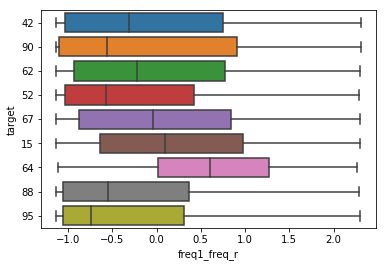

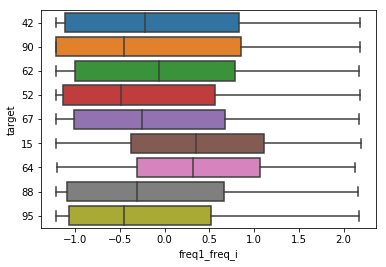

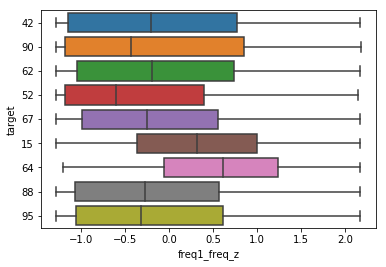

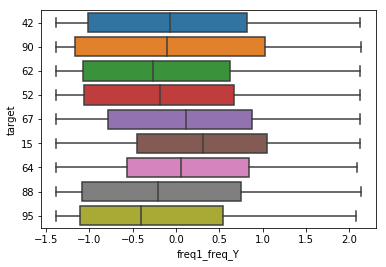

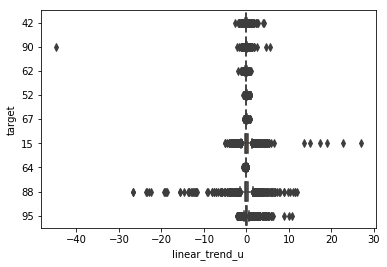

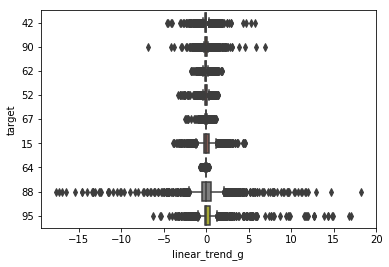

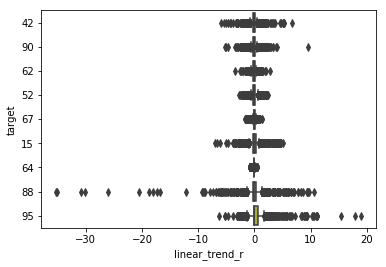

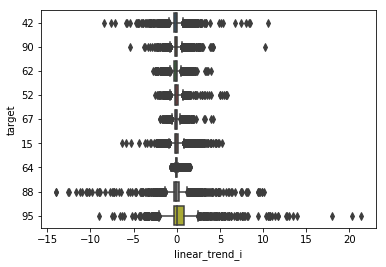

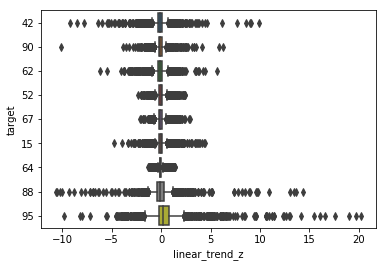

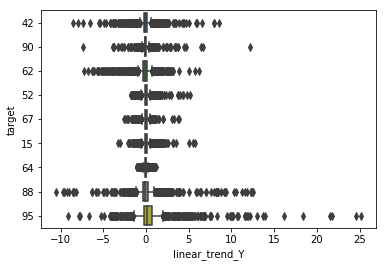

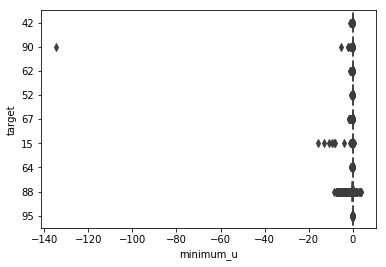

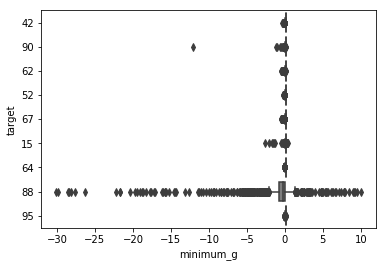

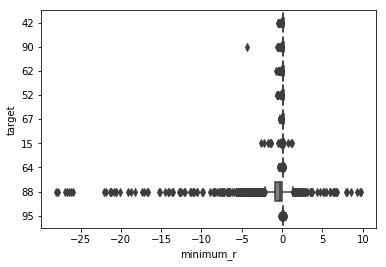

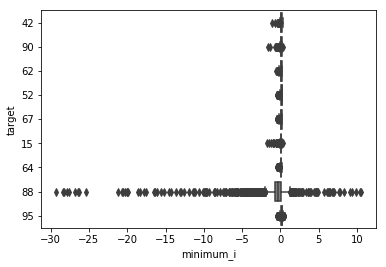

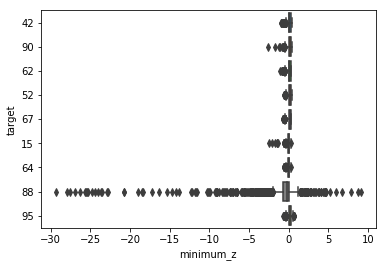

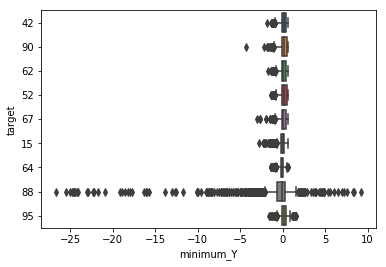

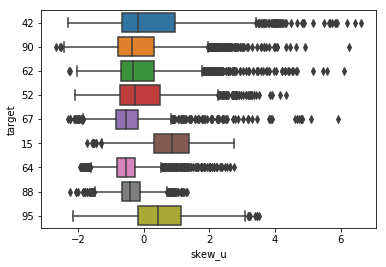

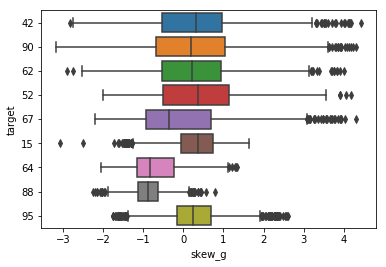

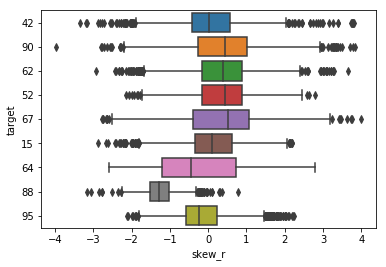

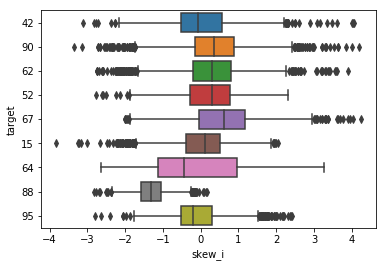

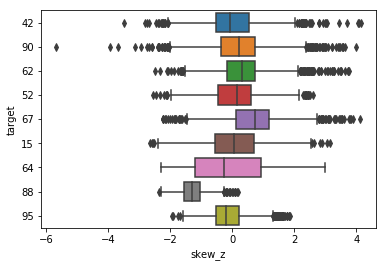

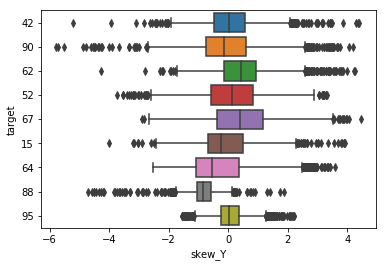

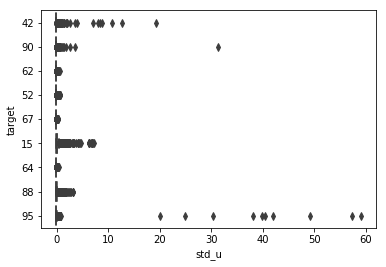

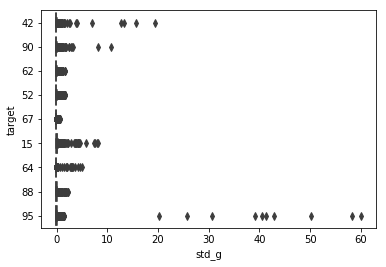

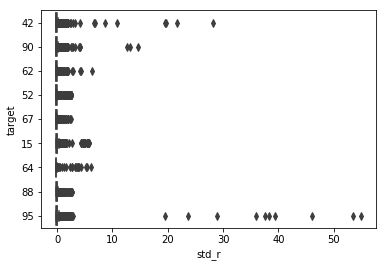

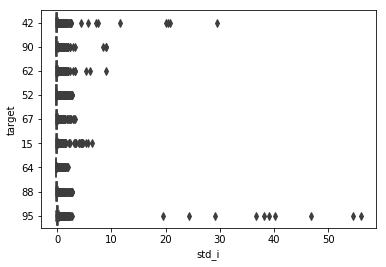

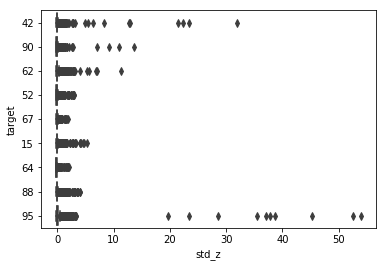

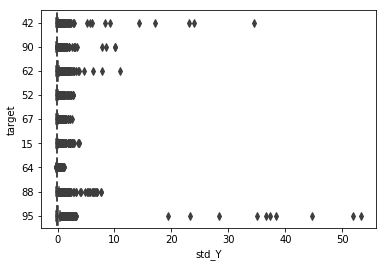

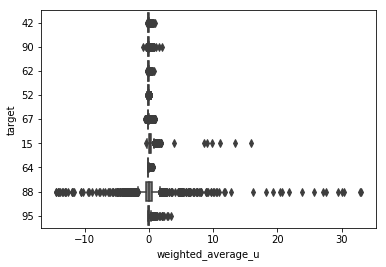

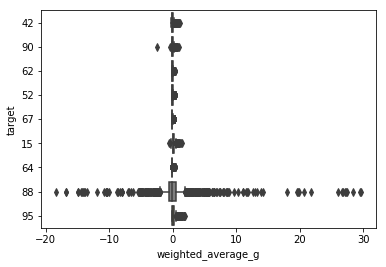

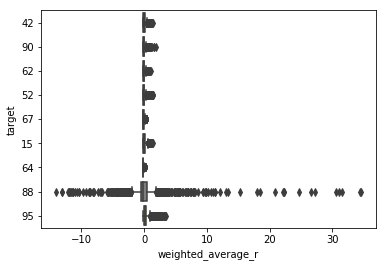

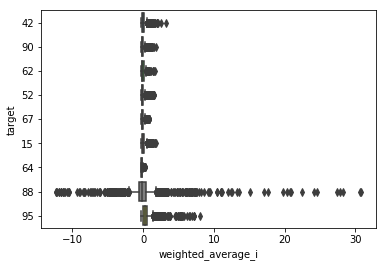

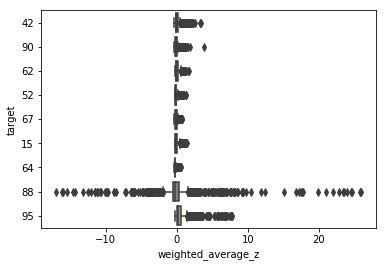

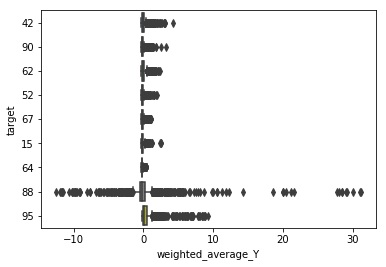

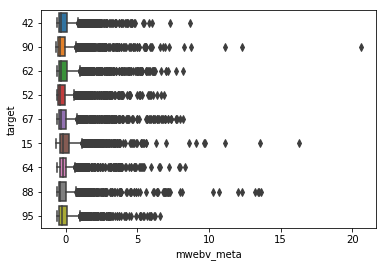

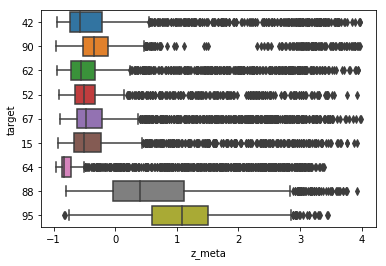

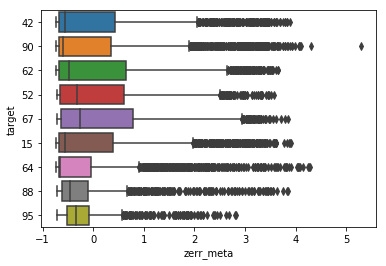

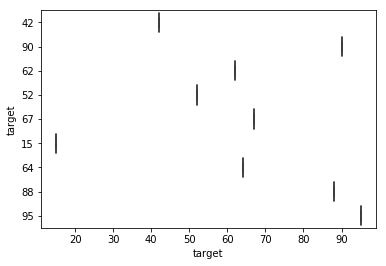

In [79]:
ss = StandardScaler()
scaled = pd.DataFrame(ss.fit_transform(df), columns=df.columns, index=df.index)
scaled['target'] = df.target
for x in scaled.columns:
    sns.boxplot(x=x, y='target', order = [42,90,62,52,67,15,64,88,95], data=scaled, orient='h')
    plt.show()

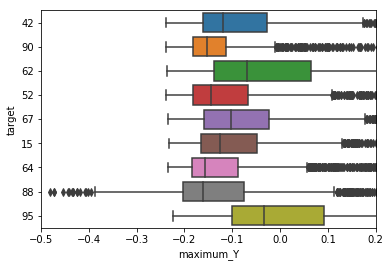

In [151]:
sns.boxplot(x='maximum_Y', y='target', order = [42,90,62,52,67,15,64,88,95], data=scaled, orient='h')
plt.xlim(-.5,.2)
plt.show()

# feature changes
#use or square hostgalspecz, photoz to emphacize 90
#amplitude_u differentiates 15. g does too and 42 v 90 a bit. I should not merge with ri.drop fliers over 10?
#amplitude_z adn Y might lift 62 past 42/90 - lower fliers to 10?
#percentbeyond1std Y puts 62 below 42,90
#Maxu lifts 42 up, but after scaled probably wouldn't because 15 is so big. lower fliers to 10?
#maxz might lift 62 upover 52, 64
#MaxY good too
#consider removing maxslope g
#Y might be the only median that's helping.  lower fliers to 10, -10?
#medabsdev i, z Y - lower fliers to 10 or 5? may not be worth it though. remove u for sure
#PeriodFastY on it's own
#qso zY only
#freq1freeq r,i
#Lin just Y
#skew r i z only
#std z + Y fliers to 10
#wa z + Y, fliers to 10

# Second attempt: change the features listed above, but don't do anything with exponents or fliers

In [80]:
egalfeats.head(1)

,numpeaks_grzY,amplitude_ug,epctbey_gr,maxes_ugizy,maxslopes_gzy,median_uizY,medianAbsDev_gzY,pct2Med_u,pct2Med_g,periodFast_riz,qlc2q_ugriY,freqSig_grizy,linear_ugriz,minimum_z,skew_grz,std_urizy,hostgal_photoz,hostgal_specz,distmod
0,3.755479,-0.015184,1.928056,0.35954,-0.653533,0.193142,-0.330144,-1.2186,-1.534092,-0.853309,-0.261363,-2.444219,-0.482318,0.246451,2.289988,0.368242,1.715845,3.035749,1.641199


In [130]:
#amplitude_z adn Y might lift 62 past 42/90 - lower fliers to 10?
ampzy = df[['amplitude_z','amplitude_Y']]
ampzy.corr()

,amplitude_z,amplitude_Y
amplitude_z,1.000000,0.978632
amplitude_Y,0.978632,1.000000


In [138]:
#These are too similar to combine. I'll use this back of the napkin comparison to see which offers the most information about
#class differences I care about
print('Z')
print('62: ',df[df.target==62]['amplitude_z'].mean(), "---", df[df.target==62]['amplitude_z'].std())
print('42: ',df[df.target==42]['amplitude_z'].mean(), "---", df[df.target==42]['amplitude_z'].std())
print('90: ',df[df.target==90]['amplitude_z'].mean(), "---", df[df.target==90]['amplitude_z'].std())

print('Y')
print('62: ',df[df.target==62]['amplitude_Y'].mean(), "---", df[df.target==62]['amplitude_Y'].std())
print('42: ',df[df.target==42]['amplitude_Y'].mean(), "---", df[df.target==42]['amplitude_Y'].std())
print('90: ',df[df.target==90]['amplitude_Y'].mean(), "---", df[df.target==90]['amplitude_Y'].std())

Z
62:  159.8698532487652 --- 290.3877349083705
42:  158.26535420510697 --- 767.6100271971804
90:  99.37102190531776 --- 289.0740010715733
Y
62:  190.92686552756848 --- 278.182793133089
42:  171.48160447679643 --- 721.6462713127588
90:  108.78169593471682 --- 255.97180013955852


In [139]:
#Y appears to be a better differentiator.

ampY_scaler = StandardScaler().fit(pd.DataFrame(df.amplitude_Y))
egalfeats['amplitude_Y'] = ampY_scaler.transform(pd.DataFrame(df.amplitude_Y))
egalfeats.head()



,numpeaks_grzY,amplitude_ug,epctbey_gr,maxes_ugizy,maxslopes_gzy,median_uizY,medianAbsDev_gzY,pct2Med_u,pct2Med_g,periodFast_riz,qlc2q_ugriY,freqSig_grizy,linear_ugriz,minimum_z,skew_grz,std_urizy,hostgal_photoz,hostgal_specz,distmod,amplitude_Y
0,3.755479,-0.015184,1.928056,0.359540,-0.653533,0.193142,-0.330144,-1.218600,-1.534092,-0.853309,-0.261363,-2.444219,-0.482318,0.246451,2.289988,0.368242,1.715845,3.035749,1.641199,-0.278772
1,2.066347,-0.012837,0.551099,0.326993,-0.651046,0.131458,-0.431809,-0.459737,-0.316842,0.088611,-1.124556,-3.056355,-0.045268,0.331307,-0.089615,0.355187,-0.596119,-0.414324,-0.426159,-0.242011
2,3.333196,0.060863,-2.079297,0.109648,-0.620984,0.117107,-0.414359,0.757307,1.661189,-1.951828,1.962863,-3.482028,-1.062260,0.204255,-4.730269,0.235126,-0.505159,-0.258362,-0.209797,-0.158370
3,3.661839,-0.000970,-0.924318,0.209062,-0.624849,0.123211,-0.423076,-0.040419,0.638069,0.109972,0.626203,-4.316538,0.140869,0.190451,-1.784424,0.276825,-0.570861,-0.498286,-0.361732,-0.189500
4,3.661839,0.491592,-2.307035,-1.044958,0.840565,0.152617,-0.452897,2.414124,1.666436,0.610842,4.247247,2.925465,0.468586,0.339325,-4.582744,-0.483792,-0.669084,-0.624882,-0.638185,0.346787


In [142]:
##percentbeyond1std Y puts 62 below 42,90
pctbeyY_scaler = StandardScaler().fit(pd.DataFrame(df.percent_beyond_1_std_Y))
egalfeats['pctBey1Std_Y'] = pctbeyY_scaler.transform(pd.DataFrame(df.percent_beyond_1_std_Y))
egalfeats.head()



,numpeaks_grzY,amplitude_ug,epctbey_gr,maxes_ugizy,maxslopes_gzy,median_uizY,medianAbsDev_gzY,pct2Med_u,pct2Med_g,periodFast_riz,...,freqSig_grizy,linear_ugriz,minimum_z,skew_grz,std_urizy,hostgal_photoz,hostgal_specz,distmod,amplitude_Y,pctBey1Std_Y
0,3.755479,-0.015184,1.928056,0.359540,-0.653533,0.193142,-0.330144,-1.218600,-1.534092,-0.853309,...,-2.444219,-0.482318,0.246451,2.289988,0.368242,1.715845,3.035749,1.641199,-0.278772,1.119954
1,2.066347,-0.012837,0.551099,0.326993,-0.651046,0.131458,-0.431809,-0.459737,-0.316842,0.088611,...,-3.056355,-0.045268,0.331307,-0.089615,0.355187,-0.596119,-0.414324,-0.426159,-0.242011,-0.544740
2,3.333196,0.060863,-2.079297,0.109648,-0.620984,0.117107,-0.414359,0.757307,1.661189,-1.951828,...,-3.482028,-1.062260,0.204255,-4.730269,0.235126,-0.505159,-0.258362,-0.209797,-0.158370,-1.717144
3,3.661839,-0.000970,-0.924318,0.209062,-0.624849,0.123211,-0.423076,-0.040419,0.638069,0.109972,...,-4.316538,0.140869,0.190451,-1.784424,0.276825,-0.570861,-0.498286,-0.361732,-0.189500,-2.076799
4,3.661839,0.491592,-2.307035,-1.044958,0.840565,0.152617,-0.452897,2.414124,1.666436,0.610842,...,2.925465,0.468586,0.339325,-4.582744,-0.483792,-0.669084,-0.624882,-0.638185,0.346787,-2.241640


In [143]:
#Maxu lifts 42 up, but after scaled probably wouldn't because 15 is so big. lower fliers to 10?
#maxz might lift 62 upover 52, 64
#MaxY good too
maxes = df[['maximum_u','maximum_z','maximum_Y']]
maxes.corr()

,maximum_u,maximum_z,maximum_Y
maximum_u,1.000000,0.894865,0.883391
maximum_z,0.894865,1.000000,0.979213
maximum_Y,0.883391,0.979213,1.000000


In [154]:
#These are so correlated. I'll just ignore u/z (too correlated with Y) and pick Y based on the charts above.
maxY_scaler = StandardScaler().fit(pd.DataFrame(df.maximum_Y))
egalfeats['max_Y'] = maxY_scaler.transform(pd.DataFrame(df.maximum_Y))
egalfeats = egalfeats.drop('maxes_ugizy', axis=1)
egalfeats.head(1)



,numpeaks_grzY,amplitude_ug,epctbey_gr,maxslopes_gzy,median_uizY,medianAbsDev_gzY,pct2Med_u,pct2Med_g,periodFast_riz,qlc2q_ugriY,...,linear_ugriz,minimum_z,skew_grz,std_urizy,hostgal_photoz,hostgal_specz,distmod,amplitude_Y,pctBey1Std_Y,max_Y
0,3.755479,-0.015184,1.928056,-0.653533,0.193142,-0.330144,-1.218600,-1.534092,-0.853309,-0.261363,...,-0.482318,0.246451,2.289988,0.368242,1.715845,3.035749,1.641199,-0.278772,1.119954,-0.232953
1,2.066347,-0.012837,0.551099,-0.651046,0.131458,-0.431809,-0.459737,-0.316842,0.088611,-1.124556,...,-0.045268,0.331307,-0.089615,0.355187,-0.596119,-0.414324,-0.426159,-0.242011,-0.544740,-0.200962
2,3.333196,0.060863,-2.079297,-0.620984,0.117107,-0.414359,0.757307,1.661189,-1.951828,1.962863,...,-1.062260,0.204255,-4.730269,0.235126,-0.505159,-0.258362,-0.209797,-0.158370,-1.717144,-0.108344
3,3.661839,-0.000970,-0.924318,-0.624849,0.123211,-0.423076,-0.040419,0.638069,0.109972,0.626203,...,0.140869,0.190451,-1.784424,0.276825,-0.570861,-0.498286,-0.361732,-0.189500,-2.076799,-0.140155
4,3.661839,0.491592,-2.307035,0.840565,0.152617,-0.452897,2.414124,1.666436,0.610842,4.247247,...,0.468586,0.339325,-4.582744,-0.483792,-0.669084,-0.624882,-0.638185,0.346787,-2.241640,0.394580


In [156]:
#Removing max slope g
emaxslopes = df[['max_slope_z','max_slope_Y']]
emaxslopes.corr()
#Combine these

,max_slope_z,max_slope_Y
max_slope_z,1.00000,0.18208
max_slope_Y,0.18208,1.00000


In [164]:
maxslopez_scaler = StandardScaler().fit(pd.DataFrame(df.max_slope_z))
egalfeats['maxslope_z'] = maxslopez_scaler.transform(pd.DataFrame(df.max_slope_z))

maxslopeY_scaler = StandardScaler().fit(pd.DataFrame(df.max_slope_Y))
egalfeats['maxslope_Y'] = maxslopeY_scaler.transform(pd.DataFrame(df.max_slope_Y))

egalfeats = egalfeats.drop('maxslopes_gzy', axis=1)

egalfeats.head(1)

,numpeaks_grzY,amplitude_ug,epctbey_gr,median_uizY,medianAbsDev_gzY,pct2Med_u,pct2Med_g,periodFast_riz,qlc2q_ugriY,freqSig_grizy,...,skew_grz,std_urizy,hostgal_photoz,hostgal_specz,distmod,amplitude_Y,pctBey1Std_Y,max_Y,maxslope_z,maxslope_Y
0,3.755479,-0.015184,1.928056,0.193142,-0.330144,-1.2186,-1.534092,-0.853309,-0.261363,-2.444219,...,2.289988,0.368242,1.715845,3.035749,1.641199,-0.278772,1.119954,-0.232953,-0.25002,-0.723283


In [166]:
#Y might be the only median that's helping.
#let's see how much info we'd lose

meds = df[['median_u', 'median_i', 'median_z', 'median_Y']]
meds.corr()

,median_u,median_i,median_z,median_Y
median_u,1.000000,0.906715,0.912394,0.917910
median_i,0.906715,1.000000,0.984607,0.951502
median_z,0.912394,0.984607,1.000000,0.958114
median_Y,0.917910,0.951502,0.958114,1.000000


In [167]:
#These are pretty correlated, so I'll risk losing them and just using Y if that helps the weak classes.

medianY_scaler = StandardScaler().fit(pd.DataFrame(df.median_Y))
egalfeats['median_Y'] = medianY_scaler.transform(pd.DataFrame(df.median_Y))

egalfeats = egalfeats.drop('median_uizY', axis=1)

egalfeats.head(1)

,numpeaks_grzY,amplitude_ug,epctbey_gr,medianAbsDev_gzY,pct2Med_u,pct2Med_g,periodFast_riz,qlc2q_ugriY,freqSig_grizy,linear_ugriz,...,std_urizy,hostgal_photoz,hostgal_specz,distmod,amplitude_Y,pctBey1Std_Y,max_Y,maxslope_z,maxslope_Y,median_Y
0,3.755479,-0.015184,1.928056,-0.330144,-1.2186,-1.534092,-0.853309,-0.261363,-2.444219,-0.482318,...,0.368242,1.715845,3.035749,1.641199,-0.278772,1.119954,-0.232953,-0.25002,-0.723283,-0.115551


In [ ]:
#medabsdev i, z Y - lower fliers to 10 or 5? may not be worth it though. remove u for sure

In [169]:
eMedAbsDev = df[['median_absolute_deviation_i', 'median_absolute_deviation_z',
       'median_absolute_deviation_Y']]
eMedAbsDev.corr()
#Combine these

,median_absolute_deviation_i,median_absolute_deviation_z,median_absolute_deviation_Y
median_absolute_deviation_i,1.000000,0.952090,0.883721
median_absolute_deviation_z,0.952090,1.000000,0.919374
median_absolute_deviation_Y,0.883721,0.919374,1.000000


In [172]:
#I shouldn't PCA these, which is most useful for the 3 poor classes?
print('i')
print('62: ',df[df.target==62]['median_absolute_deviation_i'].mean(), "---", df[df.target==62]['median_absolute_deviation_i'].std())
print('42: ',df[df.target==42]['median_absolute_deviation_i'].mean(), "---", df[df.target==42]['median_absolute_deviation_i'].std())
print('90: ',df[df.target==90]['median_absolute_deviation_i'].mean(), "---", df[df.target==90]['median_absolute_deviation_i'].std())

print('z')
print('62: ',df[df.target==62]['median_absolute_deviation_z'].mean(), "---", df[df.target==62]['median_absolute_deviation_z'].std())
print('42: ',df[df.target==42]['median_absolute_deviation_z'].mean(), "---", df[df.target==42]['median_absolute_deviation_z'].std())
print('90: ',df[df.target==90]['median_absolute_deviation_z'].mean(), "---", df[df.target==90]['median_absolute_deviation_z'].std())

print('y')
print('62: ',df[df.target==62]['median_absolute_deviation_Y'].mean(), "---", df[df.target==62]['median_absolute_deviation_Y'].std())
print('42: ',df[df.target==42]['median_absolute_deviation_Y'].mean(), "---", df[df.target==42]['median_absolute_deviation_Y'].std())
print('90: ',df[df.target==90]['median_absolute_deviation_Y'].mean(), "---", df[df.target==90]['median_absolute_deviation_Y'].std())

i
62:  4.5449956917036145 --- 2.70554776085831
42:  5.3614063366003295 --- 4.204729009551795
90:  4.370324121919585 --- 3.700767395243072
z
62:  8.593289562897642 --- 4.536777737004213
42:  9.40856188656566 --- 6.482799382518623
90:  7.587350626242973 --- 4.950171735056003
y
62:  17.949080388159267 --- 9.007424742815925
42:  18.502003113235435 --- 10.77818587831149
90:  15.173277613272807 --- 9.33023446996339


In [173]:
#I'll add z just for 42 but may remove this if I can.
eMedAbsDev_scaler = StandardScaler().fit(pd.DataFrame(df.median_absolute_deviation_z))
egalfeats['medabsev_Y'] = eMedAbsDev_scaler.transform(pd.DataFrame(df.median_absolute_deviation_z))

egalfeats = egalfeats.drop('medianAbsDev_gzY', axis=1)


In [174]:
egalfeats.head(1)

,numpeaks_grzY,amplitude_ug,epctbey_gr,pct2Med_u,pct2Med_g,periodFast_riz,qlc2q_ugriY,freqSig_grizy,linear_ugriz,minimum_z,...,hostgal_photoz,hostgal_specz,distmod,amplitude_Y,pctBey1Std_Y,max_Y,maxslope_z,maxslope_Y,median_Y,medabsev_Y
0,3.755479,-0.015184,1.928056,-1.2186,-1.534092,-0.853309,-0.261363,-2.444219,-0.482318,0.246451,...,1.715845,3.035749,1.641199,-0.278772,1.119954,-0.232953,-0.25002,-0.723283,-0.115551,-0.21402


In [175]:
#Add periodfast y on it's own
perfastY_scaler = StandardScaler().fit(pd.DataFrame(df.period_fast_Y))
egalfeats['periodFast_Y'] = perfastY_scaler.transform(pd.DataFrame(df.period_fast_Y))
egalfeats.head(1)

,numpeaks_grzY,amplitude_ug,epctbey_gr,pct2Med_u,pct2Med_g,periodFast_riz,qlc2q_ugriY,freqSig_grizy,linear_ugriz,minimum_z,...,hostgal_specz,distmod,amplitude_Y,pctBey1Std_Y,max_Y,maxslope_z,maxslope_Y,median_Y,medabsev_Y,periodFast_Y
0,3.755479,-0.015184,1.928056,-1.2186,-1.534092,-0.853309,-0.261363,-2.444219,-0.482318,0.246451,...,3.035749,1.641199,-0.278772,1.119954,-0.232953,-0.25002,-0.723283,-0.115551,-0.21402,-0.416975


In [177]:
#qso zY only

qso = df[['qso_log_chi2_qsonu_z', 'qso_log_chi2_qsonu_Y']]
qso.corr()

,qso_log_chi2_qsonu_z,qso_log_chi2_qsonu_Y
qso_log_chi2_qsonu_z,1.000000,0.890199
qso_log_chi2_qsonu_Y,0.890199,1.000000


In [178]:
print('z')
print('62: ',df[df.target==62]['qso_log_chi2_qsonu_z'].mean(), "---", df[df.target==62]['qso_log_chi2_qsonu_z'].std())
print('42: ',df[df.target==42]['qso_log_chi2_qsonu_z'].mean(), "---", df[df.target==42]['qso_log_chi2_qsonu_z'].std())
print('90: ',df[df.target==90]['qso_log_chi2_qsonu_z'].mean(), "---", df[df.target==90]['qso_log_chi2_qsonu_z'].std())

print('y')
print('62: ',df[df.target==62]['qso_log_chi2_qsonu_Y'].mean(), "---", df[df.target==62]['qso_log_chi2_qsonu_Y'].std())
print('42: ',df[df.target==42]['qso_log_chi2_qsonu_Y'].mean(), "---", df[df.target==42]['qso_log_chi2_qsonu_Y'].std())
print('90: ',df[df.target==90]['qso_log_chi2_qsonu_Y'].mean(), "---", df[df.target==90]['qso_log_chi2_qsonu_Y'].std())

z
62:  3.263069461343412 --- 1.9820886810260385
42:  3.021169498622798 --- 2.0084095990654847
90:  2.5483404846595676 --- 1.8667962632744441
y
62:  2.3339907055595277 --- 1.807477919130679
42:  1.8656872416879642 --- 1.7141723373436877
90:  1.2632889176932158 --- 1.4491229588978138


In [179]:
#Keeping only Y.

qlc2q_Y_scaler = StandardScaler().fit(pd.DataFrame(df.qso_log_chi2_qsonu_Y))
egalfeats['qlc2q_Y'] = qlc2q_Y_scaler.transform(pd.DataFrame(df.qso_log_chi2_qsonu_Y))
egalfeats = egalfeats.drop('qlc2q_ugriY', axis=1)
egalfeats.head(1)

,numpeaks_grzY,amplitude_ug,epctbey_gr,pct2Med_u,pct2Med_g,periodFast_riz,freqSig_grizy,linear_ugriz,minimum_z,skew_grz,...,distmod,amplitude_Y,pctBey1Std_Y,max_Y,maxslope_z,maxslope_Y,median_Y,medabsev_Y,periodFast_Y,qlc2q_Y
0,3.755479,-0.015184,1.928056,-1.2186,-1.534092,-0.853309,-2.444219,-0.482318,0.246451,2.289988,...,1.641199,-0.278772,1.119954,-0.232953,-0.25002,-0.723283,-0.115551,-0.21402,-0.416975,-0.638305


In [181]:
#freq1freeq r,i
ff = df[['freq1_freq_r', 'freq1_freq_i']]
ff.corr()

,freq1_freq_r,freq1_freq_i
freq1_freq_r,1.000000,0.381236
freq1_freq_i,0.381236,1.000000


In [182]:
ff_scaler = StandardScaler().fit(ff)
X = ff_scaler.transform(ff)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))
eig_val_cov



%Variance explained by each component
 [0.30938215 0.69061785]


array([0.61879402, 1.38130206])

In [183]:
P = eig_vec_cov[:, 1]
Y = P.T.dot(Xt)

egalfeats['freq1_freq_ri'] = Y

egalfeats.head(1)

,numpeaks_grzY,amplitude_ug,epctbey_gr,pct2Med_u,pct2Med_g,periodFast_riz,freqSig_grizy,linear_ugriz,minimum_z,skew_grz,...,amplitude_Y,pctBey1Std_Y,max_Y,maxslope_z,maxslope_Y,median_Y,medabsev_Y,periodFast_Y,qlc2q_Y,freq1_freq_ri
0,3.755479,-0.015184,1.928056,-1.2186,-1.534092,-0.853309,-2.444219,-0.482318,0.246451,2.289988,...,-0.278772,1.119954,-0.232953,-0.25002,-0.723283,-0.115551,-0.21402,-0.416975,-0.638305,-0.433862


In [184]:
#Linear: just Y
linear_Y_scaler = StandardScaler().fit(pd.DataFrame(df.linear_trend_Y))
egalfeats['linear_Y'] = linear_Y_scaler.transform(pd.DataFrame(df.linear_trend_Y))

egalfeats.head(1)

,numpeaks_grzY,amplitude_ug,epctbey_gr,pct2Med_u,pct2Med_g,periodFast_riz,freqSig_grizy,linear_ugriz,minimum_z,skew_grz,...,pctBey1Std_Y,max_Y,maxslope_z,maxslope_Y,median_Y,medabsev_Y,periodFast_Y,qlc2q_Y,freq1_freq_ri,linear_Y
0,3.755479,-0.015184,1.928056,-1.2186,-1.534092,-0.853309,-2.444219,-0.482318,0.246451,2.289988,...,1.119954,-0.232953,-0.25002,-0.723283,-0.115551,-0.21402,-0.416975,-0.638305,-0.433862,-0.159611


In [185]:
#skew r i z only
skews = df[['skew_r', 'skew_i', 'skew_z']]
skews.corr()

,skew_r,skew_i,skew_z
skew_r,1.000000,0.547429,0.398946
skew_i,0.547429,1.000000,0.426757
skew_z,0.398946,0.426757,1.000000


In [186]:
skew_scaler = StandardScaler().fit(skews)
X = skew_scaler.transform(skews)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))
eig_val_cov



%Variance explained by each component
 [0.63954191 0.15031573 0.21014236]


array([1.9187179 , 0.45096885, 0.63045737])

In [187]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

egalfeats['skew_riz'] = Y
egalfeats = egalfeats.drop('skew_grz', axis=1)

egalfeats.head(1)

,numpeaks_grzY,amplitude_ug,epctbey_gr,pct2Med_u,pct2Med_g,periodFast_riz,freqSig_grizy,linear_ugriz,minimum_z,std_urizy,...,max_Y,maxslope_z,maxslope_Y,median_Y,medabsev_Y,periodFast_Y,qlc2q_Y,freq1_freq_ri,linear_Y,skew_riz
0,3.755479,-0.015184,1.928056,-1.2186,-1.534092,-0.853309,-2.444219,-0.482318,0.246451,0.368242,...,-0.232953,-0.25002,-0.723283,-0.115551,-0.21402,-0.416975,-0.638305,-0.433862,-0.159611,2.574152


In [188]:
#std z + Y fliers to 10

stds = df[['std_z', 'std_Y']]
stds.corr()

,std_z,std_Y
std_z,1.000000,0.985822
std_Y,0.985822,1.000000


In [189]:
print('z')
print('62: ',df[df.target==62]['std_z'].mean(), "---", df[df.target==62]['std_z'].std())
print('42: ',df[df.target==42]['std_z'].mean(), "---", df[df.target==42]['std_z'].std())
print('90: ',df[df.target==90]['std_z'].mean(), "---", df[df.target==90]['std_z'].std())

print('y')
print('62: ',df[df.target==62]['std_Y'].mean(), "---", df[df.target==62]['std_Y'].std())
print('42: ',df[df.target==42]['std_Y'].mean(), "---", df[df.target==42]['std_Y'].std())
print('90: ',df[df.target==90]['std_Y'].mean(), "---", df[df.target==90]['std_Y'].std())

z
62:  75.99018150592336 --- 155.1732493221033
42:  79.56494885044715 --- 367.7391173141352
90:  44.70327708534468 --- 150.0957355146549
y
62:  89.2829249285423 --- 147.76321460097017
42:  82.36601564745811 --- 353.8755718514106
90:  47.972303751424064 --- 136.2416114750345


In [190]:
#Keeping Y for the smaller STDS
std_Y_scaler = StandardScaler().fit(pd.DataFrame(df.std_Y))
egalfeats['std_Y'] = std_Y_scaler.transform(pd.DataFrame(df.std_Y))
egalfeats = egalfeats.drop('std_urizy', axis=1)
egalfeats.head(1)

,numpeaks_grzY,amplitude_ug,epctbey_gr,pct2Med_u,pct2Med_g,periodFast_riz,freqSig_grizy,linear_ugriz,minimum_z,hostgal_photoz,...,maxslope_z,maxslope_Y,median_Y,medabsev_Y,periodFast_Y,qlc2q_Y,freq1_freq_ri,linear_Y,skew_riz,std_Y
0,3.755479,-0.015184,1.928056,-1.2186,-1.534092,-0.853309,-2.444219,-0.482318,0.246451,1.715845,...,-0.25002,-0.723283,-0.115551,-0.21402,-0.416975,-0.638305,-0.433862,-0.159611,2.574152,-0.224495


In [192]:
#wa z + Y, fliers to 10

wa = df[['weighted_average_z','weighted_average_Y']]
wa.corr()

,weighted_average_z,weighted_average_Y
weighted_average_z,1.000000,0.963461
weighted_average_Y,0.963461,1.000000


In [193]:
print('z')
print('62: ',df[df.target==62]['weighted_average_z'].mean(), "---", df[df.target==62]['weighted_average_z'].std())
print('42: ',df[df.target==42]['weighted_average_z'].mean(), "---", df[df.target==42]['weighted_average_z'].std())
print('90: ',df[df.target==90]['weighted_average_z'].mean(), "---", df[df.target==90]['weighted_average_z'].std())

print('y')
print('62: ',df[df.target==62]['weighted_average_Y'].mean(), "---", df[df.target==62]['weighted_average_Y'].std())
print('42: ',df[df.target==42]['weighted_average_Y'].mean(), "---", df[df.target==42]['weighted_average_Y'].std())
print('90: ',df[df.target==90]['weighted_average_Y'].mean(), "---", df[df.target==90]['weighted_average_Y'].std())

z
62:  19.64435618330946 --- 18.962171818317348
42:  21.343554994447377 --- 25.416553130411543
90:  12.286363163139725 --- 14.90354694390293
y
62:  27.56310298110552 --- 32.445555523296505
42:  24.0217292474609 --- 33.46310364287197
90:  11.493801633583821 --- 20.229237987564904


In [194]:
wa_z_scaler = StandardScaler().fit(pd.DataFrame(df.weighted_average_z))
egalfeats['wa_z'] = wa_z_scaler.transform(pd.DataFrame(df.weighted_average_z))

egalfeats.head()

,numpeaks_grzY,amplitude_ug,epctbey_gr,pct2Med_u,pct2Med_g,periodFast_riz,freqSig_grizy,linear_ugriz,minimum_z,hostgal_photoz,...,maxslope_Y,median_Y,medabsev_Y,periodFast_Y,qlc2q_Y,freq1_freq_ri,linear_Y,skew_riz,std_Y,wa_z
0,3.755479,-0.015184,1.928056,-1.218600,-1.534092,-0.853309,-2.444219,-0.482318,0.246451,1.715845,...,-0.723283,-0.115551,-0.214020,-0.416975,-0.638305,-0.433862,-0.159611,2.574152,-0.224495,-0.293350
1,2.066347,-0.012837,0.551099,-0.459737,-0.316842,0.088611,-3.056355,-0.045268,0.331307,-0.596119,...,-0.726246,-0.067417,-0.279847,0.046832,-0.039797,1.660142,0.063996,-0.839925,-0.203994,-0.208577
2,3.333196,0.060863,-2.079297,0.757307,1.661189,-1.951828,-3.482028,-1.062260,0.204255,-0.505159,...,-0.729102,-0.065428,-0.284790,0.974595,0.642489,1.660232,-0.090831,-3.158388,-0.162067,-0.096953
3,3.661839,-0.000970,-0.924318,-0.040419,0.638069,0.109972,-4.316538,0.140869,0.190451,-0.570861,...,-0.714872,-0.072892,-0.275084,-0.082832,0.341648,1.660144,0.047725,-2.152365,-0.177270,-0.151370
4,3.661839,0.491592,-2.307035,2.414124,1.666436,0.610842,2.925465,0.468586,0.339325,-0.669084,...,-0.164871,-0.104019,-0.298996,-0.256117,2.139968,1.512997,0.264695,-4.441089,0.128521,-0.153506


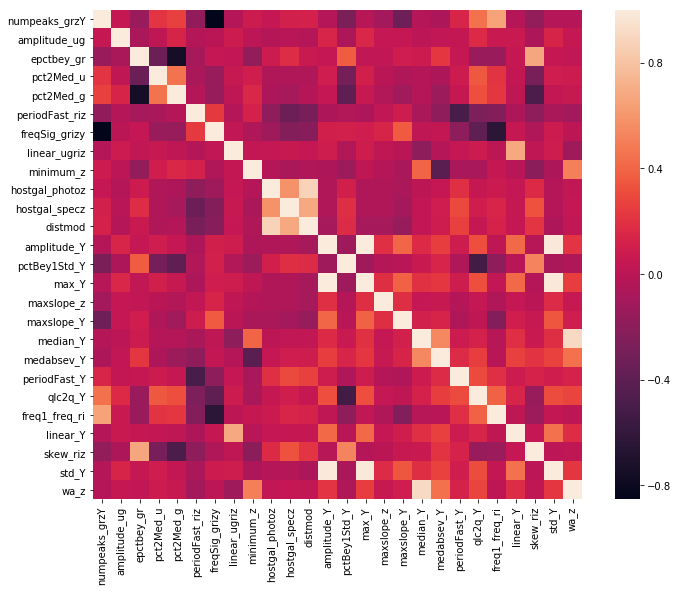

In [195]:
cor = egalfeats.corr()
plt.figure(figsize=(12,9))
sns.heatmap(cor, square=True)
plt.show()

In [196]:
#Split X,Y
egalX = egalfeats
egalY = df['target']


#Create Train/Test splits
egalX_train, egalX_test, egalY_train, egalY_test = train_test_split(
    egalX, egalY, test_size=0.5)


egalknn = KNeighborsClassifier(n_neighbors=15, weights='distance')
egalknn.fit(egalX_train, egalY_train)

egalknn.score(egalX_test, egalY_test)

0.7814391392064559

In [197]:
scores = cross_val_score(egalknn,egalX,egalY, cv=10)
display(scores)
scores.mean()

array([0.83381226, 0.82614943, 0.81896552, 0.81625782, 0.7999038 ,
       0.82251082, 0.81770082, 0.81962482, 0.82299182, 0.82202982])

0.8199946924084855

In [198]:
#This is just so I can confirm that the matrix is labelling classes correctly
counts = Counter(df['target'])
egalLabels, values = zip(*sorted(counts.items(), key=itemgetter(1)))

esrt = sorted(egalLabels)
counts

Counter({88: 2313,
         42: 2313,
         90: 2313,
         67: 2313,
         95: 2313,
         62: 2313,
         15: 2313,
         52: 2313,
         64: 2313})

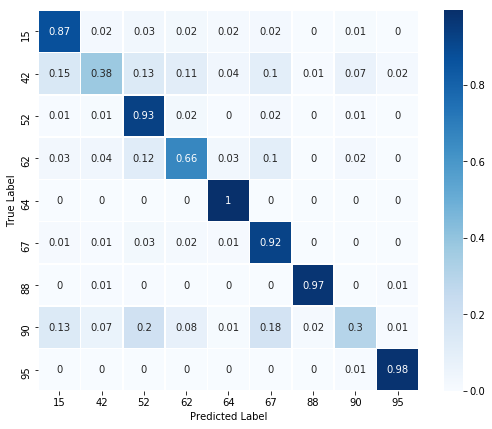

In [199]:
egalY_pred = egalknn.predict(egalX_test)
cm = confusion_matrix(egalY_test, egalY_pred,labels = esrt)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot = np.around(cm, 2)
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm, yticklabels=esrt, xticklabels=esrt, cmap='Blues',annot = annot, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')